<a href="https://colab.research.google.com/github/Satcheel/DeepRL-project/blob/master/DeepRL_three_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import namedtuple, deque
from keras.models import Model, load_model, clone_model
from keras.layers import Input, Dense, Concatenate, BatchNormalization
from keras import optimizers
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import random
import logging
import pickle


In [0]:
class Config:
  def __init__(self):
    self.episode_limit = 40000
    self.gamma = 0.1
    self.batch_size = 1000
    self.memory_limit = 50000
    self.input_dim = 4 ## for iris
    self.action = [0, 1, 2] ## just for listing
    self.EPSILON_EPOCHS = 20000
    self.EPSILON_START = 0.9
    self.EPSILON_END = 0.01
    

In [0]:
class Env:
  def __init__(self, data):
    self.config = Config()
    self.data_X = data[:,0:4]
    self.data_Y = data[:,-1]
    self.length = len(self.data_X)
    self.unexplored = np.zeros((self.length,3))
    self.state = 0
  def reset(self):
    self.data_X, self.data_Y, self.unexplored = shuffle(self.data_X, self.data_Y,self.unexplored)
    self.state = 0
  def step(self, a, l):
    terminal = 0
    if( a == l):
      r = 1
    else:
      r = -1
      terminal = 1
    self.state += 1
    if self.state == self.length:
      # terminal = 1
      self.reset()
    return r, terminal
  # def reset():



In [0]:
# from collections import namedtuple, deque
class Memory:
  def __init__(self):
    self.config = Config()
    # self.dimensions = 2*self.config.input_dim+3 ## 2 states and a, r, terminal
    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "terminal"]) ##this is just for refernce
    self.data = deque(maxlen=self.config.memory_limit)
    self.length = 0
  def put(self, s_t, a, r, s_t_1, terminal):
    e = self.experience(s_t, a, r, s_t_1, terminal)
    self.data.append(e)
    if self.length<self.config.memory_limit:
      self.length += 1 ##can wrap it for more data
  ## write code for sampling pool
  def sample(self):
    experiences = random.sample(self.data, k=self.config.batch_size)
    states = np.vstack([e.state for e in experiences if e is not None])
    actions = np.vstack([e.action for e in experiences if e is not None])
    rewards = np.vstack([e.reward for e in experiences if e is not None])
    next_states = np.vstack([e.next_state for e in experiences if e is not None])
    terminals = np.vstack([e.terminal for e in experiences if e is not None])
    return (states, actions, rewards, next_states, terminals)


In [0]:
# from keras.models import Sequential
# from keras.layers import Dense, Activation
class qNetwork:  ##keras requirement
  def __init__(self):
    self.config = Config()
    ##create neural network
    input1 = Input(shape=(4,))
    # inpu1 = BatchNormalization()(input1)
    x1 = Dense(8, activation='relu')(input1)
    # input2 = Input(shape=(1,))
    # inpu2 = BatchNormalization()(input2)
    # concated = Concatenate()([x1, input2])
    # normed = BatchNormalization(concated)
    z = Dense(4, activation='relu')(x1)
    out = Dense(1, activation='linear')(z)
    self.net_0 = Model(inputs=input1, outputs=out)
    sgd = optimizers.SGD(lr=0.001)
    ##three networks one for predicting prob for each action
    self.net_0.compile(loss='mean_squared_error', optimizer=sgd)
    self.net_1 = clone_model(self.net_0)
    self.net_1.compile(loss='mean_squared_error', optimizer=sgd)
    self.net_2 = clone_model(self.net_0)
    self.net_2.compile(loss='mean_squared_error', optimizer=sgd)
    self.net_2.summary()
  
  def load(self, filename):
    self.net = load_model(filename)

  def train(self, X_train, A_train, Y_train):  ###
    # print(X_train.shape, A_train.shape, Y_train.shape)
    error = []
    inds = np.argwhere(A_train==0)[:,0]
    # print(Y_train.shape)
    # print(X_train[inds].shape)
    # print(Y_train[inds].shape)
    if len(inds)>0:
      error.append(self.net_0.train_on_batch(X_train[inds,:], Y_train[inds,:]))
    inds = np.argwhere(A_train==1)[:,0]
    if len(inds)>0:
      error.append(self.net_1.train_on_batch(X_train[inds,:], Y_train[inds,:]))
    inds = np.argwhere(A_train==2)[:,0]
    if len(inds)>0:
      error.append(self.net_2.train_on_batch(X_train[inds,:], Y_train[inds,:]))
    self.net_0.save("/content/drive/My Drive/Colab Notebooks/iris_model_0.h5")
    self.net_1.save("/content/drive/My Drive/Colab Notebooks/iris_model_1.h5")
    self.net_2.save("/content/drive/My Drive/Colab Notebooks/iris_model_2.h5")
    return error

    
  def predict(self, s):
    ##predict using neural network Q(s,a)
    preds = np.expand_dims(self.net_0.predict(s), axis=1)
    preds = np.append(preds, np.expand_dims(self.net_1.predict(s), axis=1), axis=1)
    preds = np.append(preds, np.expand_dims(self.net_2.predict(s), axis=1), axis=1)
    return preds

In [0]:
# from sklearn.utils import shuffle
# import matplotlib.pyplot as plt
class Brain:
  def __init__(self, data):
    self.config = Config()
    self.env = Env(data)
    self.memory = Memory()
    self.qnetwork = qNetwork()
    self.epsilon = self.config.EPSILON_START
    self.ep_len_arr = []
    self.error_arr = []
    self.logger = logging.getLogger()
    fhandler = logging.FileHandler(filename='/content/drive/My Drive/Colab Notebooks/mylog.txt', mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    self.logger.addHandler(fhandler)
    self.logger.setLevel(logging.DEBUG)
    self.logger.debug("Logging started")

  def train(self):
    for epi in range(self.config.episode_limit):
      self.env.reset()
      self.logger.debug("----------------------------------------------------     Episode Start: "+str(epi)+"    ----------------------------------------------------")
      self.logger.debug("\n")
      for i in range(self.env.length):
        s_t = self.env.data_X[self.env.state]
        eps = random.random()
        if eps> self.epsilon:
          a = self.model_predict(np.expand_dims(s_t, 0))
          # a = np.argmax(q, axis=1)
        else:
          # a = np.argmax(self.env.unexplored[self.env.state,:])
          # if np.array_equal( self.env.unexplored[self.env.state,:],np.ones((1,3)) ):
          a = random.choice([0, 1, 2])
        self.logger.debug("\t Epsilon_value:"+str(eps)+"s_t:"+str(s_t)+" action:"+str(a)+" label:"+str(self.env.data_Y[self.env.state]))
        r, terminal = self.env.step(a,self.env.data_Y[self.env.state])
        self.logger.debug("\t reward:"+str(r)+" terminal:"+str(terminal))
        s_t_1 = self.env.data_X[self.env.state]
        # print("\t\t memory size before:"+str(len(self.memory.data)), end="\t")
        self.memory.put(s_t, a, r, s_t_1, terminal)
        # self.logger.debug("memory size after:"+str(len(self.memory.data)))
        if terminal:
          ## plotting graph for episode
          self.ep_len_arr.append(i)
          break
      self.logger.debug("----------------------------------------------------     Episode End: "+str(epi)+"    ----------------------------------------------------")
      self.model_train()
      self.update_epsilon(epi+1)
      if epi%100==0 and epi>0:
        self.logger.info("****************************************************     Episode Summary: "+str(epi)+"    *****************************************************")
        print("****************************************************     Episode Summary: "+str(epi)+"    *****************************************************")
        self.logger.info("Episode len: "+str(self.ep_len_arr[epi]))
        if len(self.error_arr) > 0:
          self.logger.debug("Training Done with error : "+str(self.error_arr[-1]))
          print("Training Done with error : "+str(self.error_arr[-1]))
          with open('/content/drive/My Drive/Colab Notebooks/error_array', 'wb') as f:
            pickle.dump(self.error_arr, f)
        self.logger.info("Next Epsilon value: "+str(self.epsilon))
        self.logger.info("Memory Length: "+str(len(self.memory.data)))
        plt.plot(self.ep_len_arr)
        plt.show()
        if epi%1000==0 and epi>0:
          preds = brain.model_predict(brain.env.data_X)
          self.logger.debug("preds:"+str(preds))
          print(np.argmax(preds,axis=1))
        # plt.savefig("/content/drive/My Drive/Colab Notebooks/temp.png")
        with open('/content/drive/My Drive/Colab Notebooks/ep_len_array', 'wb') as f:
          pickle.dump(self.ep_len_arr, f)
        self.logger.info("*********************************************************************************************************")

  def model_train(self):
    # implements agent function also as not so much
    ## model training using memory
    if len(self.memory.data)>=self.config.batch_size:
      (states, actions, rewards, next_states, terminals) = self.memory.sample()
      Q_targets_next = np.max(self.qnetwork.predict(next_states), axis=1)
      # self.logger.debug("Training:------Qt_next:"+str(Q_targets_next.shape), end=" ")
      # self.logger.debug("reward:"+str(rewards.shape), end=" ")
      # self.logger.debug("termial:"+str(terminals.shape), end=" ")
      Q_targets = rewards + (self.config.gamma * np.multiply(Q_targets_next, (1 - terminals)))
      # self.logger.debug("Qt_:"+str(Q_targets_.shape), end=" ")
      # Q_expected = self.qnetwork.predict(states)   ##using method as mentioned in https://www.intel.ai/demystifying-deep-reinforcement-learning/#gs.sazmxh
      # self.logger.debug("Qs:"+str(Q_expected.shape), end=" ")
      # Q_expected[:,actions] = Q_targets_
      # self.logger.debug("Qs:"+str(Q_expected.shape), end=" ")
      # Q_targets = Q_expected
      # neg_inds = Q_targets<0
      # Q_targets[neg_inds] = 0
      self.logger.debug("Qt:"+str(Q_targets) + "Actions: "+str(actions))
      # print(states.shape)
      # print(actions.shape)
      # print(Q_targets.shape)
      error = self.qnetwork.train(states, actions, Q_targets)
      self.error_arr.append(error)
      


  def model_predict(self,input_X):
  #   result = np.expand_dims(self.qnetwork.predict(input_X, np.zeros((input_X.shape[0],1))), axis=1)
  #   result = np.append(result, np.expand_dims(self.qnetwork.predict(input_X, np.ones((input_X.shape[0],1))), axis=1), axis=1)
  #   result = np.append(result, np.expand_dims(self.qnetwork.predict(input_X, np.ones((input_X.shape[0],1))*2), axis=1), axis=1)
    result = self.qnetwork.predict(input_X)
    return np.argmax(result, axis=1)

  def update_epsilon(self, epoch):
    if epoch >= self.config.EPSILON_EPOCHS:
      self.epsilon = self.config.EPSILON_END
    else:
      self.epsilon = self.config.EPSILON_START + epoch * (self.config.EPSILON_END - self.config.EPSILON_START) / self.config.EPSILON_EPOCHS



In [0]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
iris_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/iris.data",header=None)
# print(cereal_df.head(5))
data = iris_df.to_numpy()
Y = data[:,-1]
enc = LabelEncoder()
data[:,-1] = enc.fit_transform(data[:,-1])
data = data.astype('float')
# print(data[49:51],data[99:101])

brain = Brain(data)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 5         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


****************************************************     Episode Summary: 100    *****************************************************


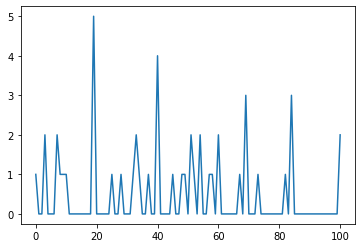

****************************************************     Episode Summary: 200    *****************************************************


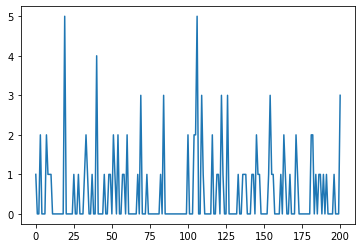

****************************************************     Episode Summary: 300    *****************************************************


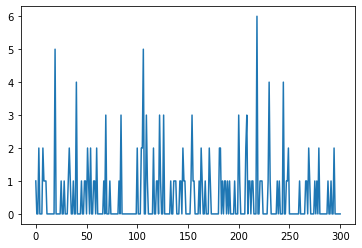

****************************************************     Episode Summary: 400    *****************************************************


****************************************************     Episode Summary: 500    *****************************************************


****************************************************     Episode Summary: 600    *****************************************************


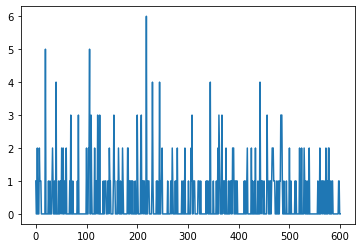

****************************************************     Episode Summary: 700    *****************************************************
Training Done with error : [1.2269355, 0.99929506, 0.6920947]


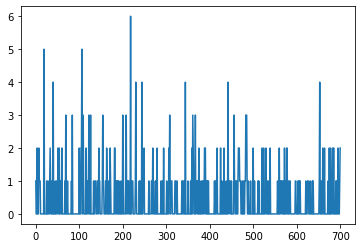

****************************************************     Episode Summary: 800    *****************************************************
Training Done with error : [0.93103737, 0.9638133, 0.6022009]


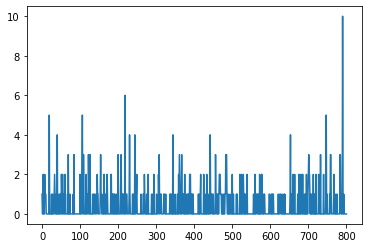

****************************************************     Episode Summary: 900    *****************************************************
Training Done with error : [0.8774467, 0.94274193, 0.5591636]


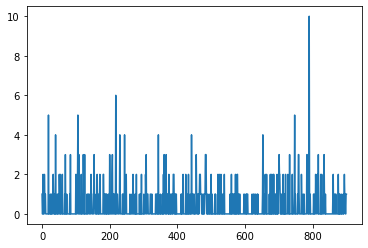

****************************************************     Episode Summary: 1000    *****************************************************
Training Done with error : [0.55180156, 0.9427802, 0.55765253]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 1100    *****************************************************
Training Done with error : [0.33510005, 0.9327155, 0.5503918]


****************************************************     Episode Summary: 1200    *****************************************************
Training Done with error : [0.1877192, 0.91977805, 0.53725123]


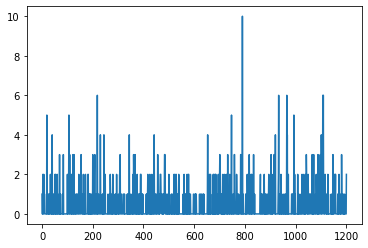

****************************************************     Episode Summary: 1300    *****************************************************
Training Done with error : [0.13002034, 0.87026346, 0.5263499]


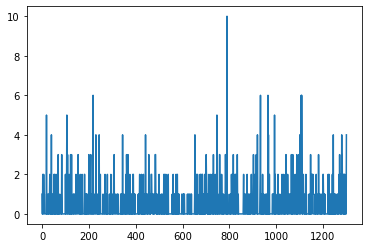

****************************************************     Episode Summary: 1400    *****************************************************
Training Done with error : [0.09988068, 0.91321635, 0.56478995]


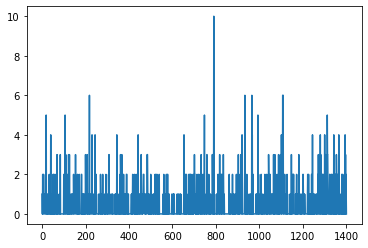

****************************************************     Episode Summary: 1500    *****************************************************
Training Done with error : [0.06675591, 0.87964916, 0.49341473]


****************************************************     Episode Summary: 1600    *****************************************************
Training Done with error : [0.058555063, 0.92143226, 0.5010991]


****************************************************     Episode Summary: 1700    *****************************************************
Training Done with error : [0.04960046, 0.9275659, 0.47387815]


****************************************************     Episode Summary: 1800    *****************************************************
Training Done with error : [0.051486574, 0.88978237, 0.48075902]


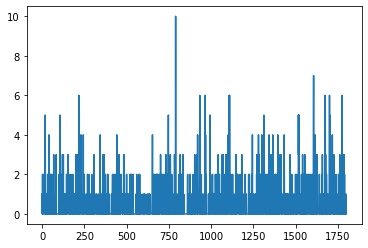

****************************************************     Episode Summary: 1900    *****************************************************
Training Done with error : [0.04256168, 0.90848756, 0.45972037]


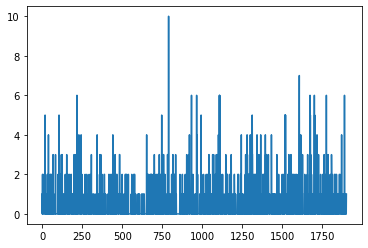

****************************************************     Episode Summary: 2000    *****************************************************
Training Done with error : [0.04012114, 0.94823545, 0.4815195]


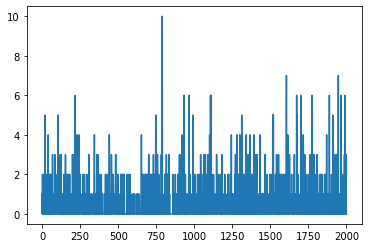

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 2100    *****************************************************
Training Done with error : [0.043016702, 0.9136283, 0.47462186]


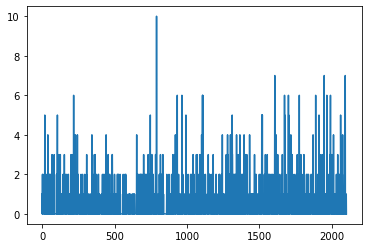

****************************************************     Episode Summary: 2200    *****************************************************
Training Done with error : [0.04479565, 0.9411527, 0.46393782]


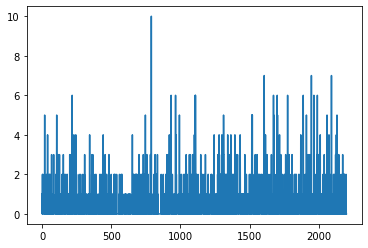

****************************************************     Episode Summary: 2300    *****************************************************
Training Done with error : [0.043992534, 0.9070802, 0.44413945]


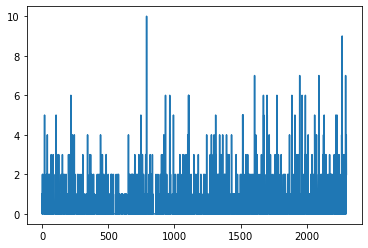

****************************************************     Episode Summary: 2400    *****************************************************
Training Done with error : [0.039973192, 0.92758065, 0.46821803]


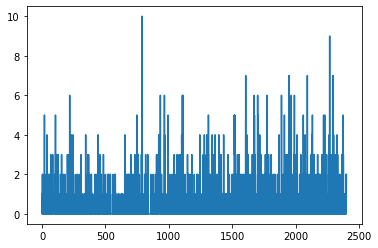

****************************************************     Episode Summary: 2500    *****************************************************
Training Done with error : [0.03496429, 0.9051195, 0.47254592]


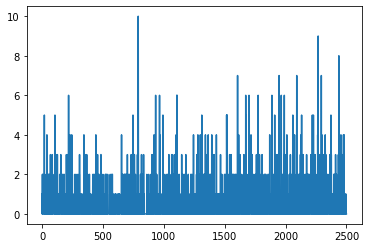

****************************************************     Episode Summary: 2600    *****************************************************
Training Done with error : [0.038083002, 0.8713988, 0.45606062]


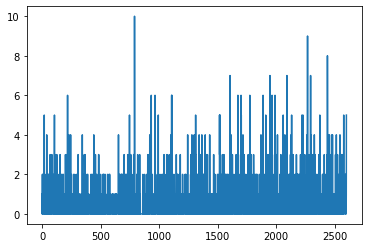

****************************************************     Episode Summary: 2700    *****************************************************
Training Done with error : [0.041360117, 0.91008437, 0.43616328]


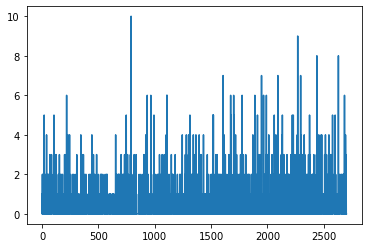

****************************************************     Episode Summary: 2800    *****************************************************
Training Done with error : [0.039024208, 0.9202429, 0.46122557]


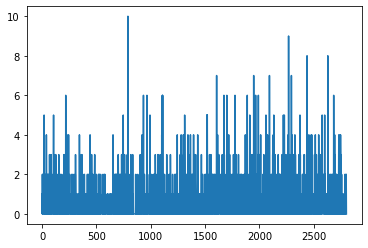

****************************************************     Episode Summary: 2900    *****************************************************
Training Done with error : [0.037232712, 0.90572655, 0.45255014]


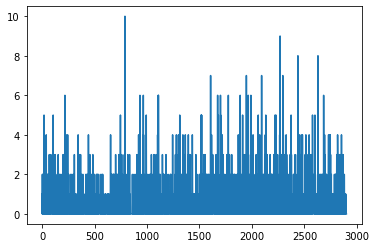

****************************************************     Episode Summary: 3000    *****************************************************
Training Done with error : [0.040143136, 0.95617115, 0.4298696]


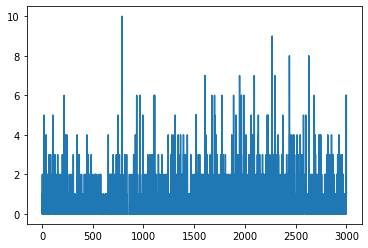

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 3100    *****************************************************
Training Done with error : [0.035997845, 0.9325527, 0.4224839]


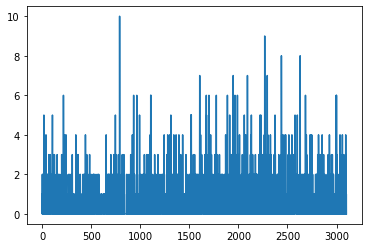

****************************************************     Episode Summary: 3200    *****************************************************
Training Done with error : [0.030519694, 0.97319424, 0.4399923]


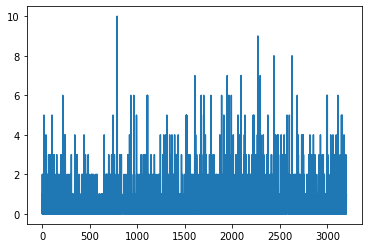

****************************************************     Episode Summary: 3300    *****************************************************
Training Done with error : [0.032063004, 0.87442833, 0.44113895]


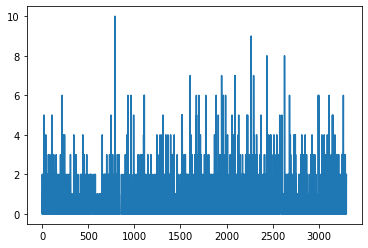

****************************************************     Episode Summary: 3400    *****************************************************
Training Done with error : [0.035818305, 0.9654793, 0.4287674]


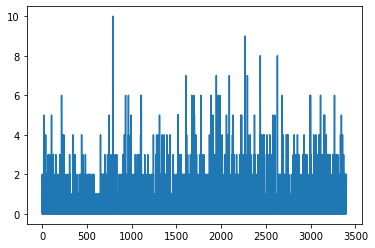

****************************************************     Episode Summary: 3500    *****************************************************
Training Done with error : [0.029139373, 0.95174474, 0.43014473]


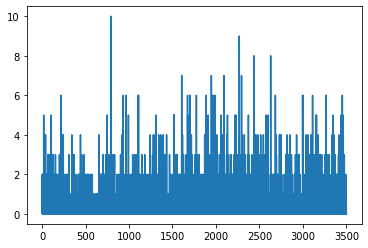

****************************************************     Episode Summary: 3600    *****************************************************
Training Done with error : [0.03350804, 1.0219892, 0.44468388]


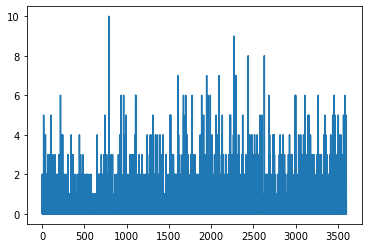

****************************************************     Episode Summary: 3700    *****************************************************
Training Done with error : [0.032414537, 0.96727747, 0.42739114]


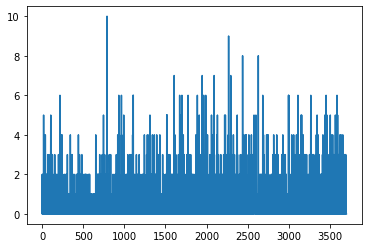

****************************************************     Episode Summary: 3800    *****************************************************
Training Done with error : [0.03168671, 0.9212822, 0.42951658]


****************************************************     Episode Summary: 3900    *****************************************************
Training Done with error : [0.03016098, 0.90607476, 0.44331405]


****************************************************     Episode Summary: 4000    *****************************************************
Training Done with error : [0.027854614, 0.9461269, 0.46036133]


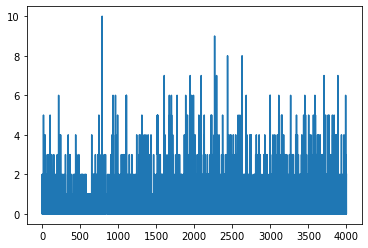

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 4100    *****************************************************
Training Done with error : [0.027503686, 0.92091614, 0.43498847]


****************************************************     Episode Summary: 4200    *****************************************************
Training Done with error : [0.0261304, 0.95249975, 0.415398]


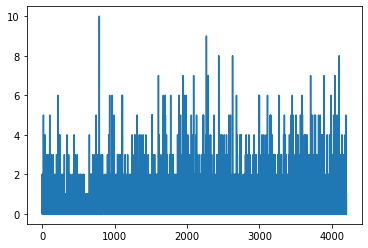

****************************************************     Episode Summary: 4300    *****************************************************
Training Done with error : [0.03207487, 0.97960055, 0.44860116]


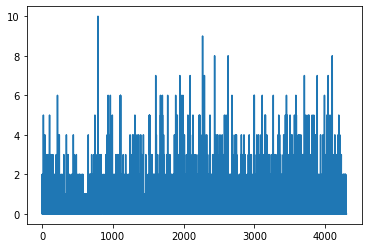

****************************************************     Episode Summary: 4400    *****************************************************
Training Done with error : [0.022715956, 0.91594124, 0.43956074]


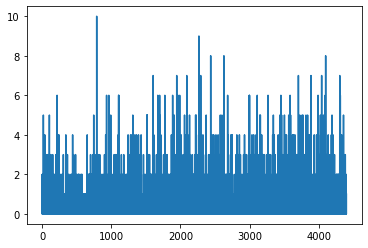

****************************************************     Episode Summary: 4500    *****************************************************
Training Done with error : [0.028650044, 0.97849977, 0.43010482]


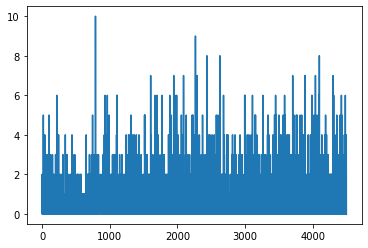

****************************************************     Episode Summary: 4600    *****************************************************
Training Done with error : [0.02888942, 0.9626595, 0.46062005]


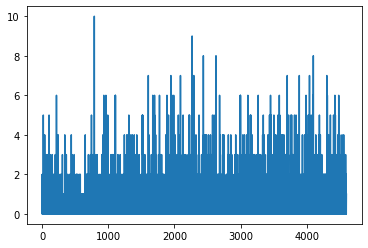

****************************************************     Episode Summary: 4700    *****************************************************
Training Done with error : [0.03087178, 0.9451764, 0.43256712]


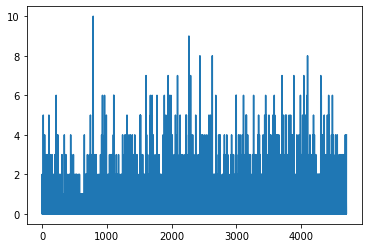

****************************************************     Episode Summary: 4800    *****************************************************
Training Done with error : [0.02416699, 0.9498451, 0.45337135]


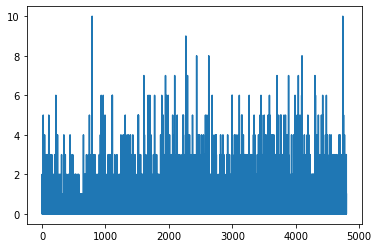

****************************************************     Episode Summary: 4900    *****************************************************
Training Done with error : [0.025823709, 0.97703445, 0.4551318]


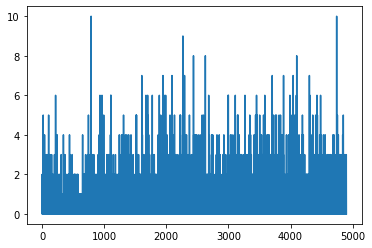

****************************************************     Episode Summary: 5000    *****************************************************
Training Done with error : [0.024014464, 0.9718522, 0.42423147]


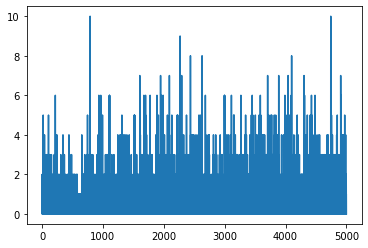

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 5100    *****************************************************
Training Done with error : [0.02242798, 0.9407811, 0.44496965]


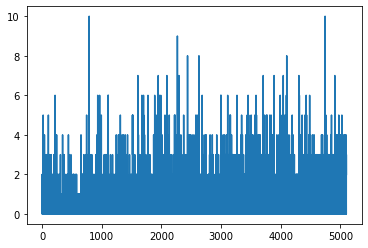

****************************************************     Episode Summary: 5200    *****************************************************
Training Done with error : [0.022140997, 0.9734017, 0.45493314]


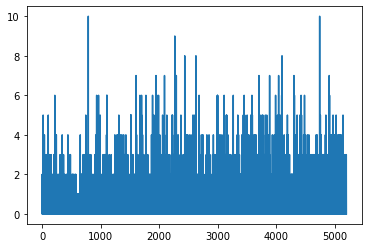

****************************************************     Episode Summary: 5300    *****************************************************
Training Done with error : [0.023588665, 0.89648706, 0.40482953]


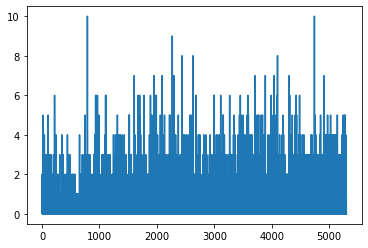

****************************************************     Episode Summary: 5400    *****************************************************
Training Done with error : [0.024426341, 0.9799398, 0.44286972]


****************************************************     Episode Summary: 5500    *****************************************************
Training Done with error : [0.024228713, 1.002676, 0.4583306]


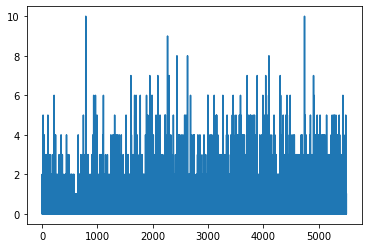

****************************************************     Episode Summary: 5600    *****************************************************
Training Done with error : [0.021985542, 0.9797577, 0.4144543]


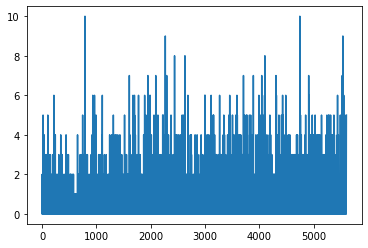

****************************************************     Episode Summary: 5700    *****************************************************
Training Done with error : [0.020189222, 0.9497902, 0.43724495]


****************************************************     Episode Summary: 5800    *****************************************************
Training Done with error : [0.020175435, 0.9158773, 0.45224604]


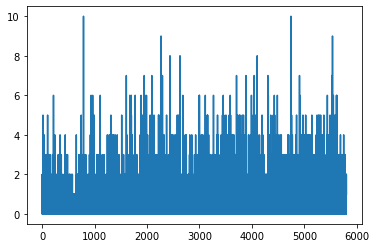

****************************************************     Episode Summary: 5900    *****************************************************
Training Done with error : [0.021014242, 0.9690757, 0.42333877]


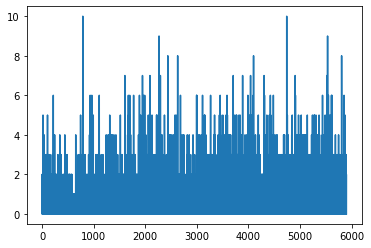

****************************************************     Episode Summary: 6000    *****************************************************
Training Done with error : [0.0203599, 0.9555895, 0.45980397]


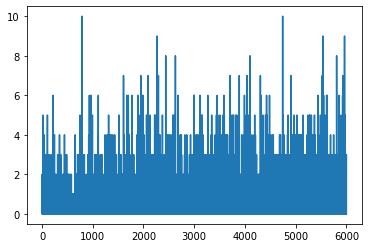

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 6100    *****************************************************
Training Done with error : [0.019965352, 1.0249002, 0.46096042]


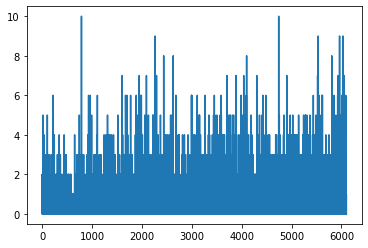

****************************************************     Episode Summary: 6200    *****************************************************
Training Done with error : [0.018100735, 0.95086247, 0.4462506]


****************************************************     Episode Summary: 6300    *****************************************************
Training Done with error : [0.017391507, 0.9882804, 0.42803612]


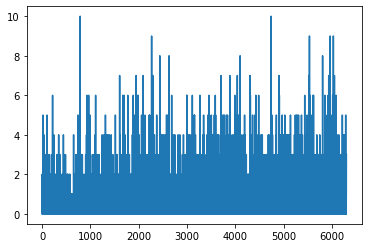

****************************************************     Episode Summary: 6400    *****************************************************
Training Done with error : [0.02210141, 1.0023515, 0.448722]


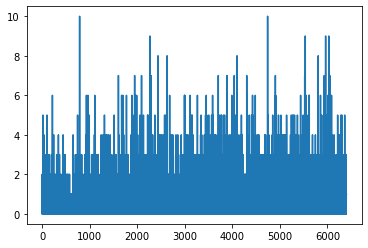

****************************************************     Episode Summary: 6500    *****************************************************
Training Done with error : [0.01828658, 1.0009323, 0.42151538]


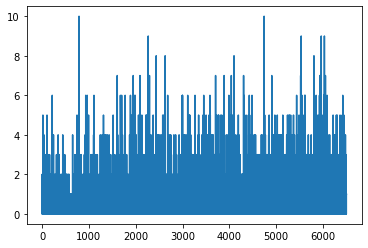

****************************************************     Episode Summary: 6600    *****************************************************
Training Done with error : [0.0211693, 0.9700207, 0.44078818]


****************************************************     Episode Summary: 6700    *****************************************************
Training Done with error : [0.017010042, 1.0609323, 0.46111017]


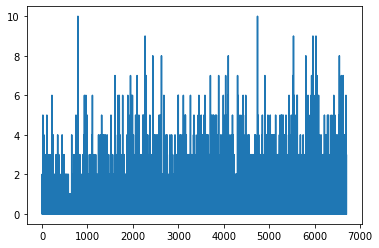

****************************************************     Episode Summary: 6800    *****************************************************
Training Done with error : [0.019480051, 1.0020899, 0.42587823]


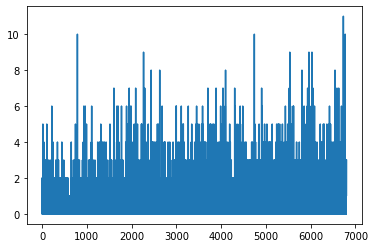

****************************************************     Episode Summary: 6900    *****************************************************
Training Done with error : [0.020044712, 1.0213585, 0.42363665]


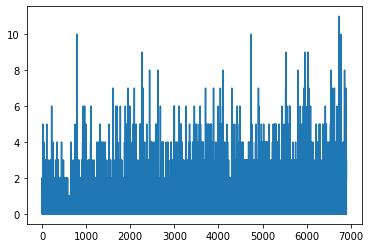

****************************************************     Episode Summary: 7000    *****************************************************
Training Done with error : [0.018664654, 0.9820599, 0.46370426]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 7100    *****************************************************
Training Done with error : [0.015016306, 0.96083724, 0.4300622]


****************************************************     Episode Summary: 7200    *****************************************************
Training Done with error : [0.014185103, 1.0211153, 0.46465197]


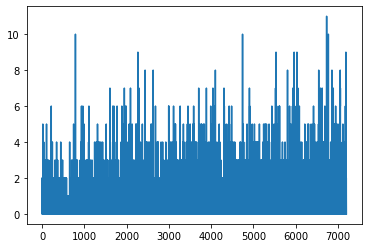

****************************************************     Episode Summary: 7300    *****************************************************
Training Done with error : [0.01676772, 1.0565623, 0.47224683]


****************************************************     Episode Summary: 7400    *****************************************************
Training Done with error : [0.015937144, 1.020299, 0.44783714]


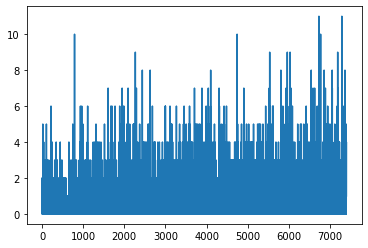

****************************************************     Episode Summary: 7500    *****************************************************
Training Done with error : [0.017343339, 1.0050224, 0.42722118]


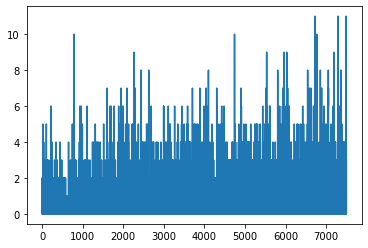

****************************************************     Episode Summary: 7600    *****************************************************
Training Done with error : [0.015734883, 1.0063041, 0.45129207]


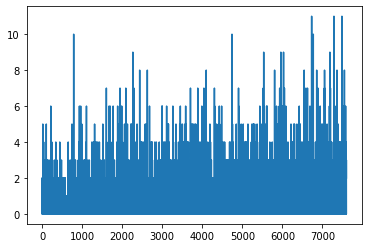

****************************************************     Episode Summary: 7700    *****************************************************
Training Done with error : [0.014648573, 1.053407, 0.44451305]


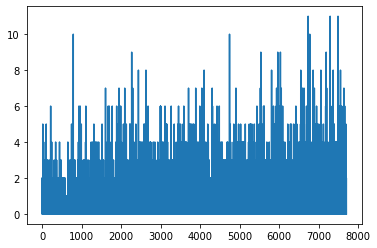

****************************************************     Episode Summary: 7800    *****************************************************
Training Done with error : [0.016562197, 0.9955396, 0.46136707]


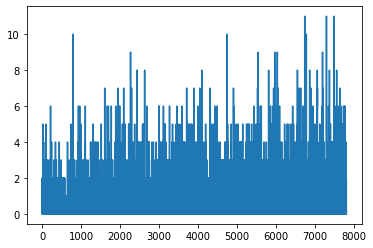

****************************************************     Episode Summary: 7900    *****************************************************
Training Done with error : [0.015072012, 1.0268013, 0.48886672]


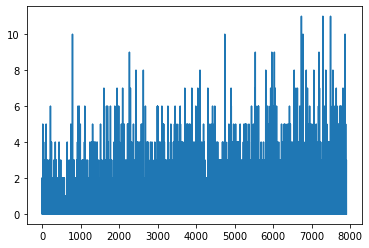

****************************************************     Episode Summary: 8000    *****************************************************
Training Done with error : [0.01651292, 1.0144285, 0.46855104]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 8100    *****************************************************
Training Done with error : [0.0136374505, 1.0256387, 0.43212438]


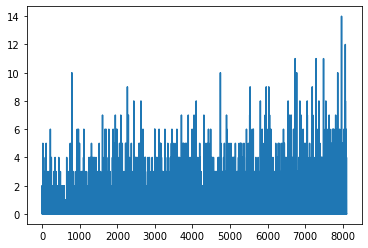

****************************************************     Episode Summary: 8200    *****************************************************
Training Done with error : [0.014406307, 1.0382118, 0.42953655]


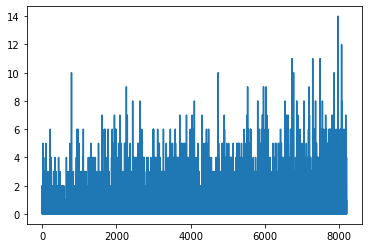

****************************************************     Episode Summary: 8300    *****************************************************
Training Done with error : [0.01587666, 1.0168066, 0.4525656]


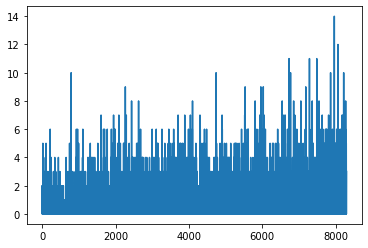

****************************************************     Episode Summary: 8400    *****************************************************
Training Done with error : [0.013911775, 1.0051353, 0.4109357]


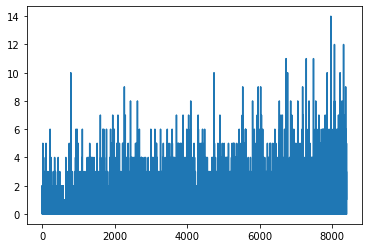

****************************************************     Episode Summary: 8500    *****************************************************
Training Done with error : [0.015111132, 1.047098, 0.41933876]


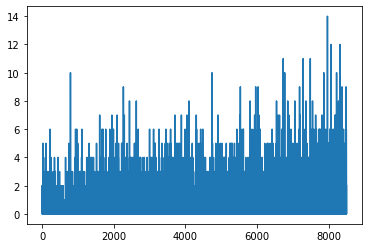

****************************************************     Episode Summary: 8600    *****************************************************
Training Done with error : [0.013183374, 0.993384, 0.46049747]


****************************************************     Episode Summary: 8700    *****************************************************
Training Done with error : [0.013530679, 1.0093559, 0.4643569]


****************************************************     Episode Summary: 8800    *****************************************************
Training Done with error : [0.012848369, 1.0795773, 0.45602557]


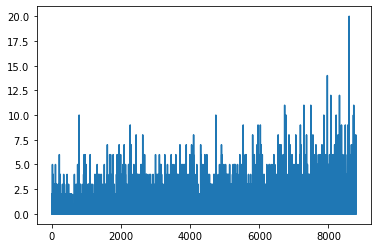

****************************************************     Episode Summary: 8900    *****************************************************
Training Done with error : [0.013725498, 1.0585448, 0.4677319]


****************************************************     Episode Summary: 9000    *****************************************************
Training Done with error : [0.013199972, 1.0366327, 0.46765003]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 9100    *****************************************************
Training Done with error : [0.012622129, 1.0492764, 0.45549586]


****************************************************     Episode Summary: 9200    *****************************************************
Training Done with error : [0.013075211, 1.0720938, 0.45648247]


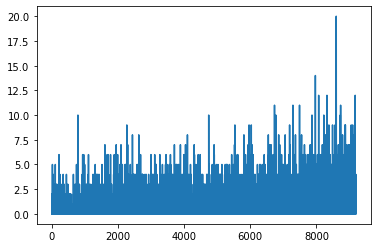

****************************************************     Episode Summary: 9300    *****************************************************
Training Done with error : [0.014758809, 1.0430361, 0.39595088]


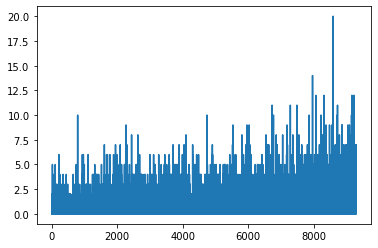

****************************************************     Episode Summary: 9400    *****************************************************
Training Done with error : [0.012788539, 1.041194, 0.44610295]


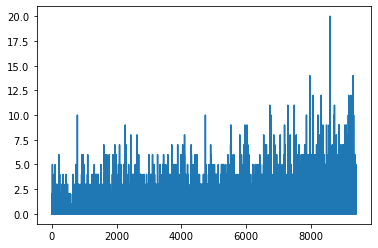

****************************************************     Episode Summary: 9500    *****************************************************
Training Done with error : [0.012501247, 1.0110565, 0.4639671]


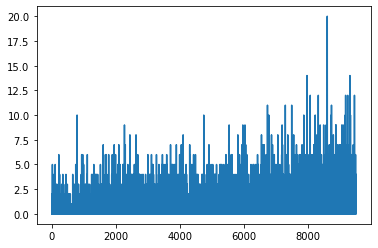

****************************************************     Episode Summary: 9600    *****************************************************
Training Done with error : [0.013772209, 1.0543367, 0.43076688]


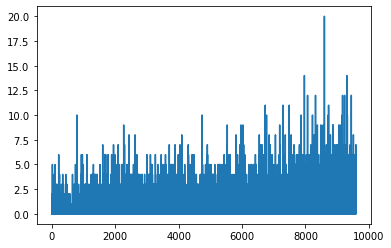

****************************************************     Episode Summary: 9700    *****************************************************
Training Done with error : [0.012266711, 1.0105671, 0.4468449]


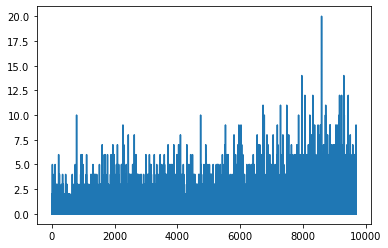

****************************************************     Episode Summary: 9800    *****************************************************
Training Done with error : [0.012005525, 1.0262384, 0.4178512]


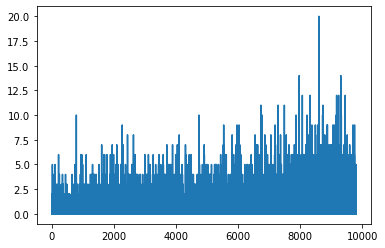

****************************************************     Episode Summary: 9900    *****************************************************
Training Done with error : [0.012450624, 1.0546905, 0.44954574]


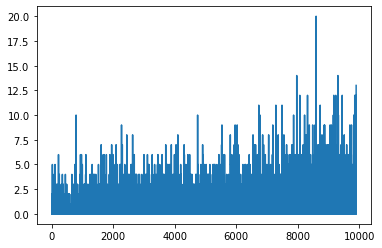

****************************************************     Episode Summary: 10000    *****************************************************
Training Done with error : [0.0115136895, 1.0562226, 0.41898543]


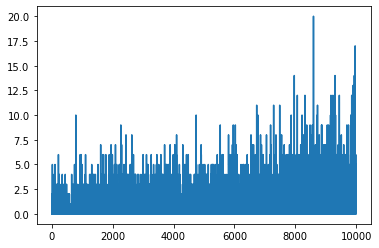

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 10100    *****************************************************
Training Done with error : [0.012275493, 1.0471752, 0.43577698]


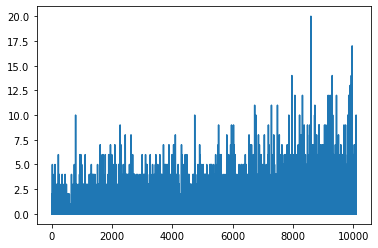

****************************************************     Episode Summary: 10200    *****************************************************
Training Done with error : [0.01174913, 1.0433067, 0.45497409]


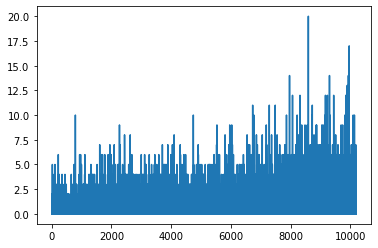

****************************************************     Episode Summary: 10300    *****************************************************
Training Done with error : [0.01069343, 1.060461, 0.42849192]


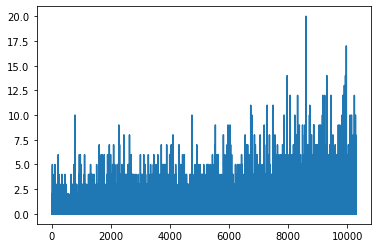

****************************************************     Episode Summary: 10400    *****************************************************
Training Done with error : [0.011691118, 1.047666, 0.41892073]


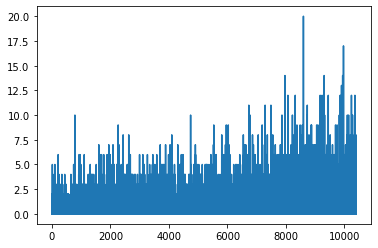

****************************************************     Episode Summary: 10500    *****************************************************
Training Done with error : [0.012463457, 1.0501236, 0.45056087]


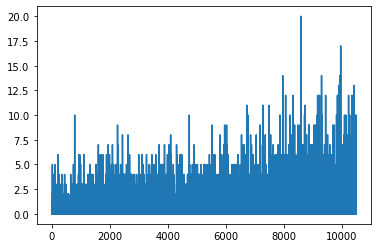

****************************************************     Episode Summary: 10600    *****************************************************
Training Done with error : [0.01060777, 1.0472283, 0.418199]


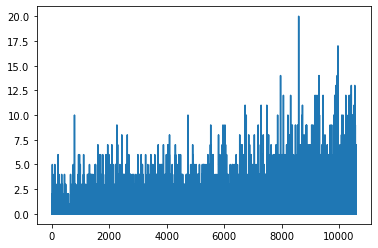

****************************************************     Episode Summary: 10700    *****************************************************
Training Done with error : [0.01133881, 1.0428863, 0.44294608]


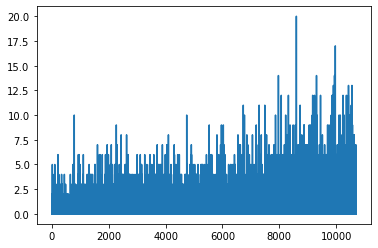

****************************************************     Episode Summary: 10800    *****************************************************
Training Done with error : [0.011818781, 1.0503623, 0.43438834]


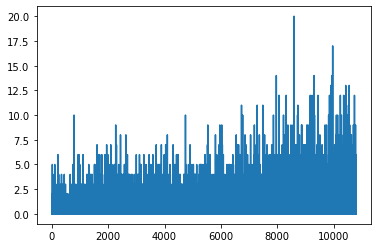

****************************************************     Episode Summary: 10900    *****************************************************
Training Done with error : [0.009761261, 1.055743, 0.4581417]


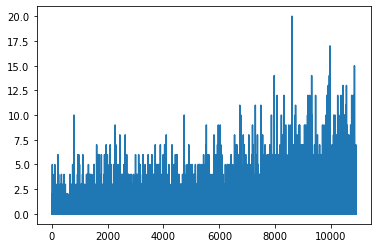

****************************************************     Episode Summary: 11000    *****************************************************
Training Done with error : [0.010451828, 1.0595247, 0.43372318]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 11100    *****************************************************
Training Done with error : [0.00963403, 1.0532583, 0.4757675]


****************************************************     Episode Summary: 11200    *****************************************************
Training Done with error : [0.009588264, 1.0628995, 0.4285697]


****************************************************     Episode Summary: 11300    *****************************************************
Training Done with error : [0.01119024, 1.0689763, 0.45650545]


****************************************************     Episode Summary: 11400    *****************************************************
Training Done with error : [0.010182349, 1.0553864, 0.44854522]


****************************************************     Episode Summary: 11500    *****************************************************
Training Done with error : [0.010719933, 1.0578393, 0.48304453]


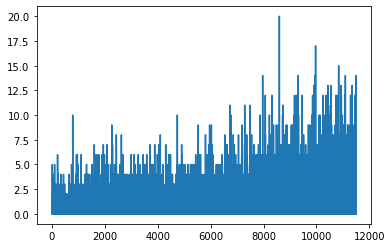

****************************************************     Episode Summary: 11600    *****************************************************
Training Done with error : [0.011827197, 1.0571319, 0.44452748]


****************************************************     Episode Summary: 11700    *****************************************************
Training Done with error : [0.011609482, 1.048064, 0.46467116]


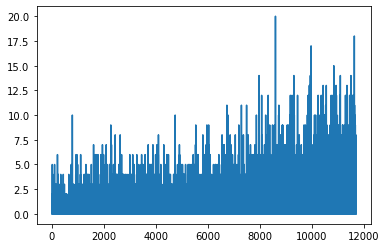

****************************************************     Episode Summary: 11800    *****************************************************
Training Done with error : [0.011113901, 1.0590138, 0.43666047]


****************************************************     Episode Summary: 11900    *****************************************************
Training Done with error : [0.011346616, 1.0550861, 0.44065884]


****************************************************     Episode Summary: 12000    *****************************************************
Training Done with error : [0.010453464, 1.0565319, 0.4827251]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 12100    *****************************************************
Training Done with error : [0.010407371, 1.067593, 0.42923772]


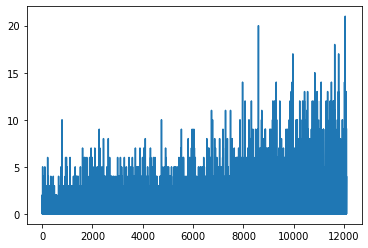

****************************************************     Episode Summary: 12200    *****************************************************
Training Done with error : [0.009301325, 1.0717144, 0.45310616]


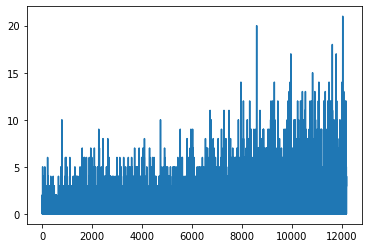

****************************************************     Episode Summary: 12300    *****************************************************
Training Done with error : [0.009201765, 1.0564109, 0.45125553]


****************************************************     Episode Summary: 12400    *****************************************************
Training Done with error : [0.009134574, 1.061654, 0.42860788]


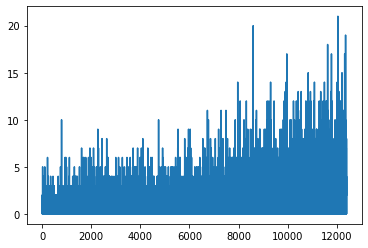

****************************************************     Episode Summary: 12500    *****************************************************
Training Done with error : [0.009263739, 1.0564517, 0.45087945]


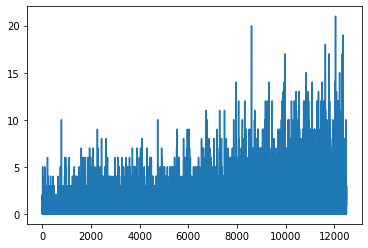

****************************************************     Episode Summary: 12600    *****************************************************
Training Done with error : [0.01156768, 1.0534055, 0.4701879]


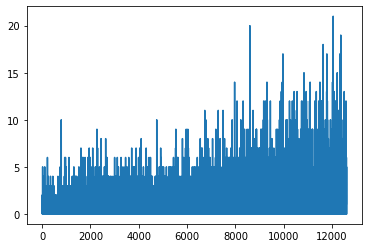

****************************************************     Episode Summary: 12700    *****************************************************
Training Done with error : [0.0097020855, 1.0574179, 0.39935887]


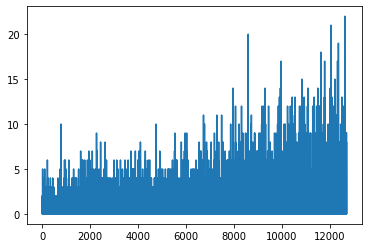

****************************************************     Episode Summary: 12800    *****************************************************
Training Done with error : [0.009146018, 1.0739022, 0.4655494]


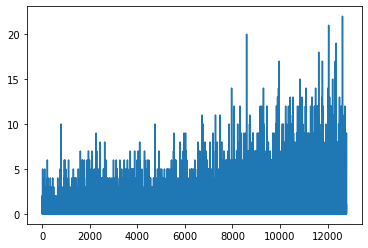

****************************************************     Episode Summary: 12900    *****************************************************
Training Done with error : [0.009654212, 1.0569105, 0.3999927]


****************************************************     Episode Summary: 13000    *****************************************************
Training Done with error : [0.008967186, 1.0632608, 0.45332903]


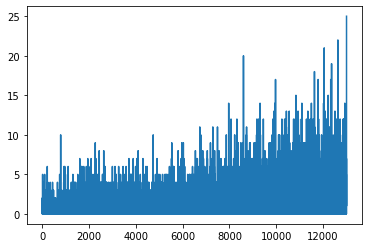

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 13100    *****************************************************
Training Done with error : [0.009940827, 1.0647409, 0.43075383]


****************************************************     Episode Summary: 13200    *****************************************************
Training Done with error : [0.008916169, 1.0596975, 0.40765214]


****************************************************     Episode Summary: 13300    *****************************************************
Training Done with error : [0.010099693, 1.0499858, 0.4664894]


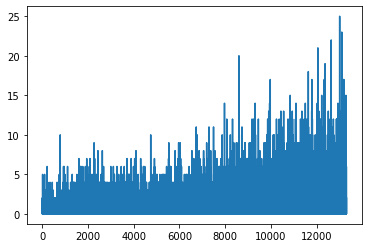

****************************************************     Episode Summary: 13400    *****************************************************
Training Done with error : [0.0091790855, 1.0512882, 0.43583503]


****************************************************     Episode Summary: 13500    *****************************************************
Training Done with error : [0.009292195, 1.0565902, 0.4557746]


****************************************************     Episode Summary: 13600    *****************************************************
Training Done with error : [0.008687179, 1.0385153, 0.4190163]


****************************************************     Episode Summary: 13700    *****************************************************
Training Done with error : [0.0077255797, 1.0589355, 0.46207714]


****************************************************     Episode Summary: 13800    *****************************************************
Training Done with error : [0.008424229, 1.0587947, 0.4399119]


****************************************************     Episode Summary: 13900    *****************************************************
Training Done with error : [0.008986577, 1.0526062, 0.4415451]


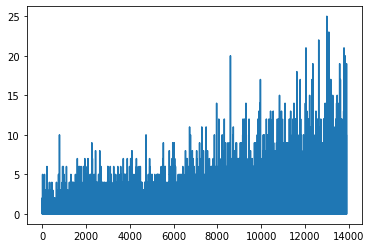

****************************************************     Episode Summary: 14000    *****************************************************
Training Done with error : [0.009020423, 1.0511794, 0.45761228]


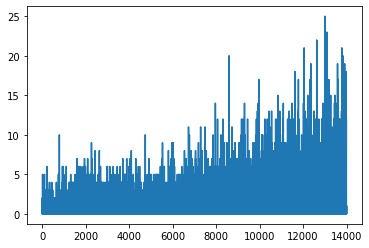

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 14100    *****************************************************
Training Done with error : [0.008666481, 1.0580246, 0.40247604]


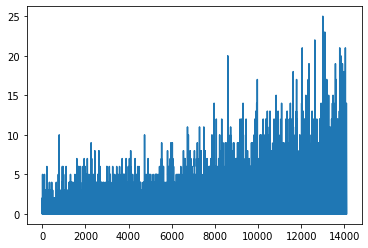

****************************************************     Episode Summary: 14200    *****************************************************
Training Done with error : [0.010127772, 1.0366838, 0.45713627]


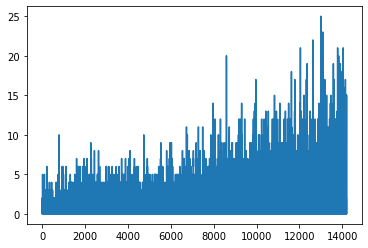

****************************************************     Episode Summary: 14300    *****************************************************
Training Done with error : [0.009096199, 1.0210617, 0.4345699]


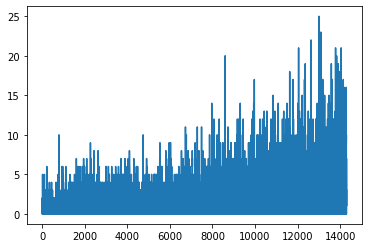

****************************************************     Episode Summary: 14400    *****************************************************
Training Done with error : [0.01013981, 1.0498841, 0.43098643]


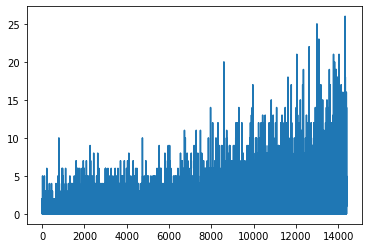

****************************************************     Episode Summary: 14500    *****************************************************
Training Done with error : [0.008006632, 1.0653763, 0.441884]


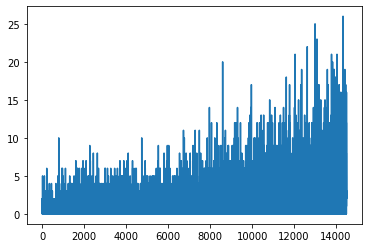

****************************************************     Episode Summary: 14600    *****************************************************
Training Done with error : [0.008432015, 1.0512546, 0.3960247]


****************************************************     Episode Summary: 14700    *****************************************************
Training Done with error : [0.008831975, 1.0541668, 0.41731843]


****************************************************     Episode Summary: 14800    *****************************************************
Training Done with error : [0.007409644, 1.0426463, 0.45880303]


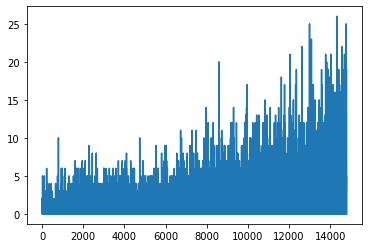

****************************************************     Episode Summary: 14900    *****************************************************
Training Done with error : [0.007790981, 1.0210623, 0.45369282]


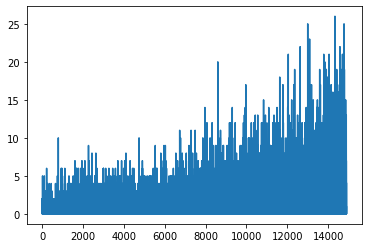

****************************************************     Episode Summary: 15000    *****************************************************
Training Done with error : [0.0076171597, 1.0293754, 0.38010755]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 15100    *****************************************************
Training Done with error : [0.008111681, 1.0431931, 0.4125523]


****************************************************     Episode Summary: 15200    *****************************************************
Training Done with error : [0.007915295, 1.0379802, 0.39537266]


****************************************************     Episode Summary: 15300    *****************************************************
Training Done with error : [0.008365671, 1.0427197, 0.4474457]


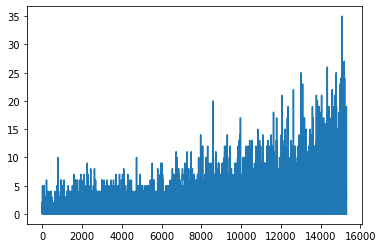

****************************************************     Episode Summary: 15400    *****************************************************
Training Done with error : [0.008542704, 0.98136276, 0.39677307]


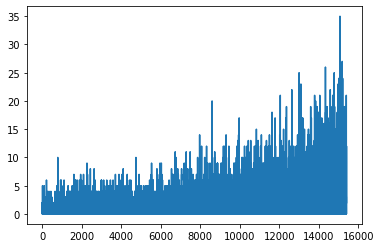

****************************************************     Episode Summary: 15500    *****************************************************
Training Done with error : [0.007744486, 1.0199826, 0.4132371]


****************************************************     Episode Summary: 15600    *****************************************************
Training Done with error : [0.0078092474, 1.0156866, 0.462943]


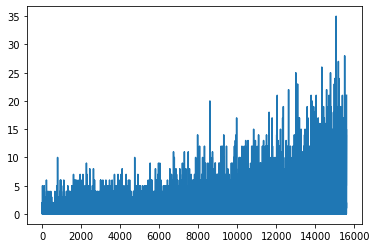

****************************************************     Episode Summary: 15700    *****************************************************
Training Done with error : [0.0066014165, 1.0360965, 0.3807449]


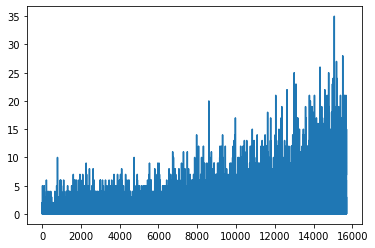

****************************************************     Episode Summary: 15800    *****************************************************
Training Done with error : [0.008107456, 1.0134996, 0.4261946]


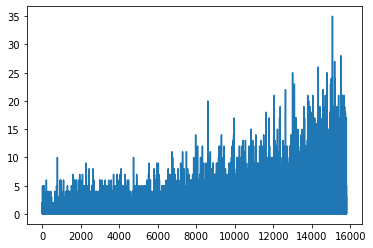

****************************************************     Episode Summary: 15900    *****************************************************
Training Done with error : [0.007717428, 1.0000492, 0.42137718]


****************************************************     Episode Summary: 16000    *****************************************************
Training Done with error : [0.0069505093, 0.9809689, 0.39139467]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 16100    *****************************************************
Training Done with error : [0.008112639, 1.0013689, 0.42394498]


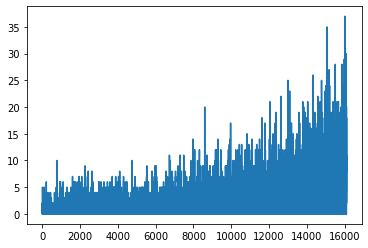

****************************************************     Episode Summary: 16200    *****************************************************
Training Done with error : [0.0076911263, 1.0454082, 0.42075813]


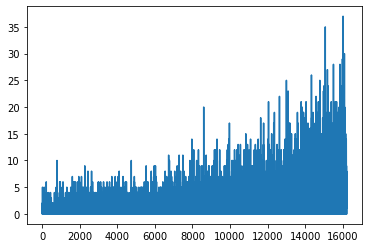

****************************************************     Episode Summary: 16300    *****************************************************
Training Done with error : [0.00822511, 1.0401974, 0.3845596]


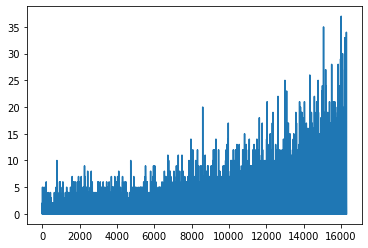

****************************************************     Episode Summary: 16400    *****************************************************
Training Done with error : [0.0097109135, 1.0395212, 0.40346542]


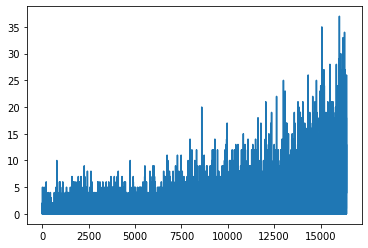

****************************************************     Episode Summary: 16500    *****************************************************
Training Done with error : [0.0077351644, 1.027811, 0.3975186]


****************************************************     Episode Summary: 16600    *****************************************************
Training Done with error : [0.0079722265, 0.9591968, 0.4122583]


****************************************************     Episode Summary: 16700    *****************************************************
Training Done with error : [0.0072572553, 1.0124829, 0.4055382]


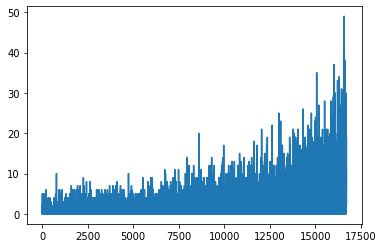

****************************************************     Episode Summary: 16800    *****************************************************
Training Done with error : [0.0071385447, 0.94816583, 0.37400642]


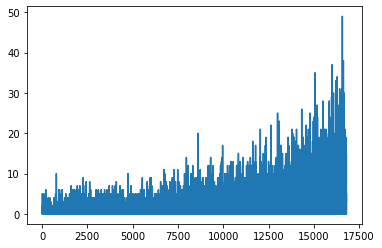

****************************************************     Episode Summary: 16900    *****************************************************
Training Done with error : [0.007121578, 0.98076737, 0.37923858]


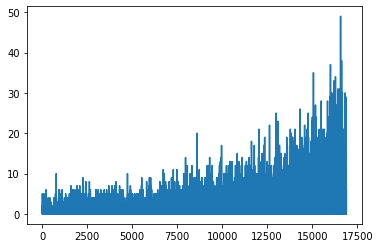

****************************************************     Episode Summary: 17000    *****************************************************
Training Done with error : [0.0077196346, 0.9835619, 0.34599707]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 17100    *****************************************************
Training Done with error : [0.007424198, 0.92938644, 0.37516493]


****************************************************     Episode Summary: 17200    *****************************************************
Training Done with error : [0.008302155, 0.9752167, 0.34844694]


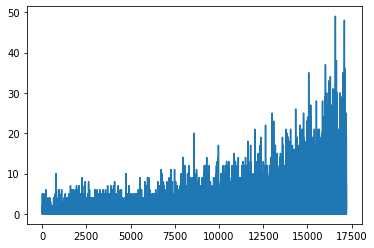

****************************************************     Episode Summary: 17300    *****************************************************
Training Done with error : [0.0076711834, 0.9062434, 0.36100903]


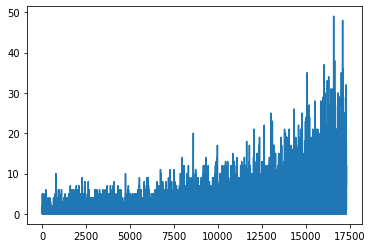

****************************************************     Episode Summary: 17400    *****************************************************
Training Done with error : [0.0077363625, 0.9580498, 0.38439807]


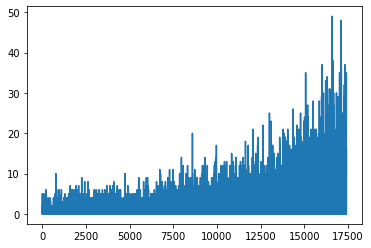

****************************************************     Episode Summary: 17500    *****************************************************
Training Done with error : [0.007598337, 0.9589373, 0.36006716]


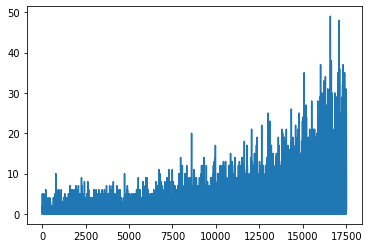

****************************************************     Episode Summary: 17600    *****************************************************
Training Done with error : [0.0068503423, 0.93678707, 0.35811922]


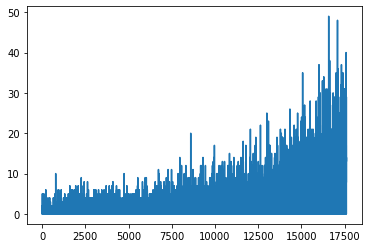

****************************************************     Episode Summary: 17700    *****************************************************
Training Done with error : [0.0070263627, 0.8791075, 0.36519665]


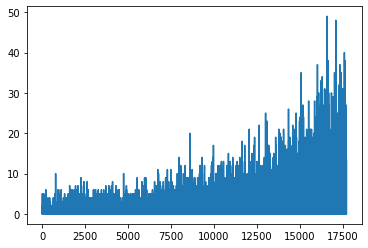

****************************************************     Episode Summary: 17800    *****************************************************
Training Done with error : [0.00764282, 0.7982063, 0.38517103]


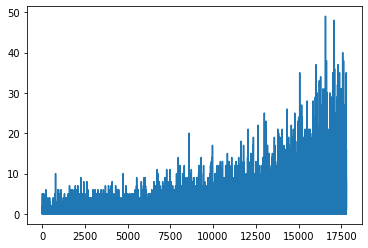

****************************************************     Episode Summary: 17900    *****************************************************
Training Done with error : [0.006842689, 0.831905, 0.37245256]


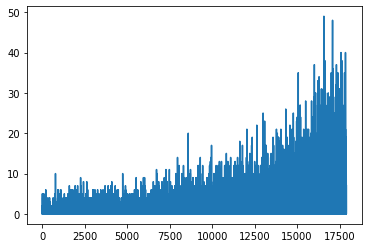

****************************************************     Episode Summary: 18000    *****************************************************
Training Done with error : [0.0075535285, 0.8376483, 0.36391854]


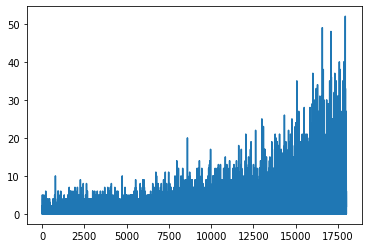

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 18100    *****************************************************
Training Done with error : [0.007755681, 0.7637987, 0.3417037]


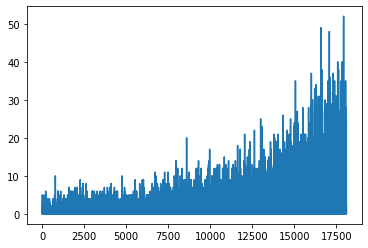

****************************************************     Episode Summary: 18200    *****************************************************
Training Done with error : [0.0067582307, 0.84928447, 0.37687594]


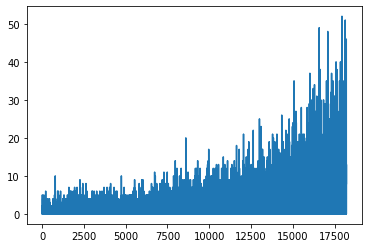

****************************************************     Episode Summary: 18300    *****************************************************
Training Done with error : [0.008517791, 0.7250144, 0.31150693]


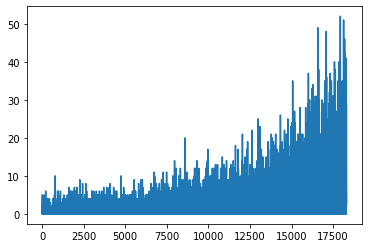

****************************************************     Episode Summary: 18400    *****************************************************
Training Done with error : [0.006763337, 0.7778744, 0.34924605]


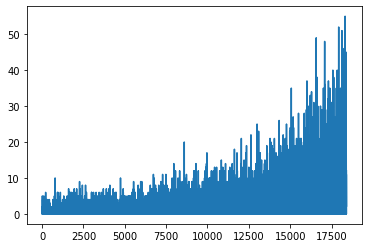

****************************************************     Episode Summary: 18500    *****************************************************
Training Done with error : [0.0062240358, 0.7149174, 0.32648918]


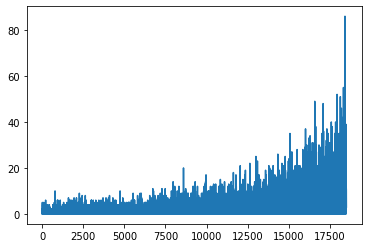

****************************************************     Episode Summary: 18600    *****************************************************
Training Done with error : [0.006372009, 0.750576, 0.34927094]


****************************************************     Episode Summary: 18700    *****************************************************
Training Done with error : [0.006765792, 0.8009659, 0.334769]


****************************************************     Episode Summary: 18800    *****************************************************
Training Done with error : [0.005983081, 0.7248812, 0.32828772]


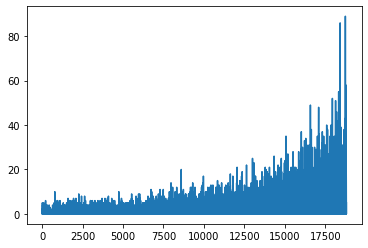

****************************************************     Episode Summary: 18900    *****************************************************
Training Done with error : [0.007114815, 0.7355746, 0.31056568]


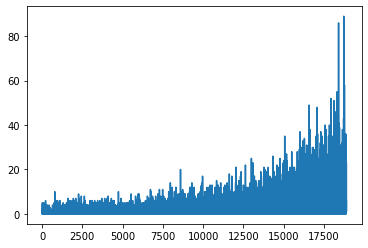

****************************************************     Episode Summary: 19000    *****************************************************
Training Done with error : [0.006085814, 0.7475434, 0.2657195]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 19100    *****************************************************
Training Done with error : [0.0071404832, 0.67808694, 0.24994819]


****************************************************     Episode Summary: 19200    *****************************************************
Training Done with error : [0.0062401895, 0.6525976, 0.33051026]


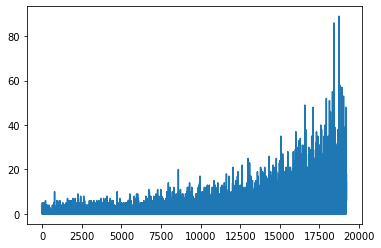

****************************************************     Episode Summary: 19300    *****************************************************
Training Done with error : [0.0066691935, 0.7808411, 0.2426092]


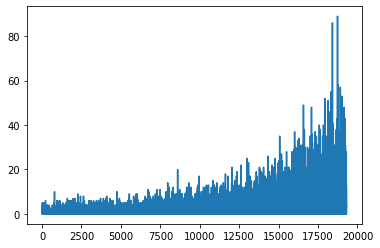

****************************************************     Episode Summary: 19400    *****************************************************
Training Done with error : [0.0066606426, 0.6503623, 0.26096714]


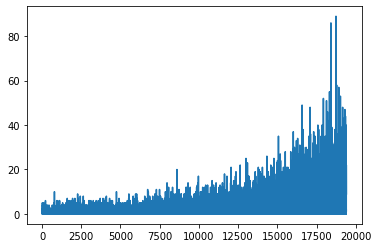

****************************************************     Episode Summary: 19500    *****************************************************
Training Done with error : [0.0069069215, 0.7017455, 0.2465001]


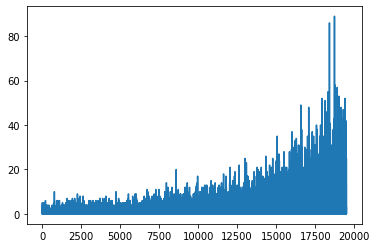

****************************************************     Episode Summary: 19600    *****************************************************
Training Done with error : [0.0072472463, 0.62439585, 0.20675527]


****************************************************     Episode Summary: 19700    *****************************************************
Training Done with error : [0.00592623, 0.6842759, 0.18957306]


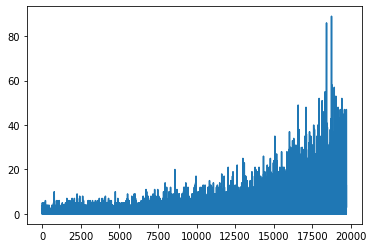

****************************************************     Episode Summary: 19800    *****************************************************
Training Done with error : [0.0056317234, 0.6188037, 0.21048747]


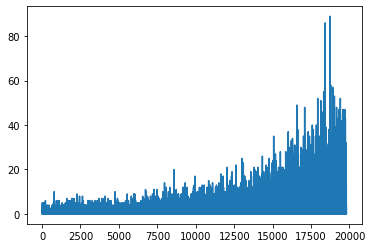

****************************************************     Episode Summary: 19900    *****************************************************
Training Done with error : [0.0071424567, 0.706191, 0.2271833]


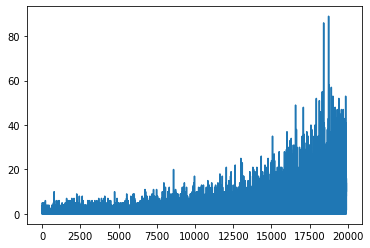

****************************************************     Episode Summary: 20000    *****************************************************
Training Done with error : [0.006180542, 0.68985057, 0.288008]


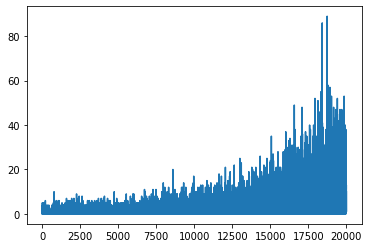

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 20100    *****************************************************
Training Done with error : [0.006411014, 0.69698465, 0.24130645]


****************************************************     Episode Summary: 20200    *****************************************************
Training Done with error : [0.006687472, 0.62367177, 0.24097769]


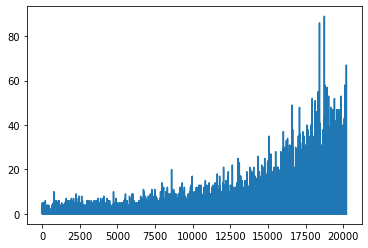

****************************************************     Episode Summary: 20300    *****************************************************
Training Done with error : [0.0060329167, 0.6930863, 0.20761038]


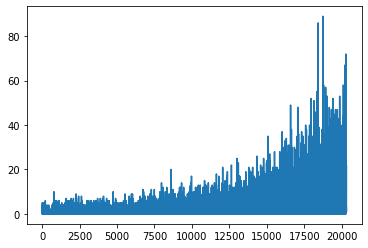

****************************************************     Episode Summary: 20400    *****************************************************
Training Done with error : [0.006298613, 0.68198663, 0.22592662]


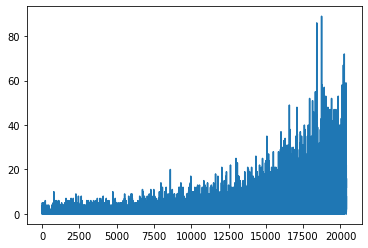

****************************************************     Episode Summary: 20500    *****************************************************
Training Done with error : [0.0054827896, 0.68066794, 0.1945343]


****************************************************     Episode Summary: 20600    *****************************************************
Training Done with error : [0.006000337, 0.6957332, 0.17287631]


****************************************************     Episode Summary: 20700    *****************************************************
Training Done with error : [0.0067229257, 0.6984832, 0.14960305]


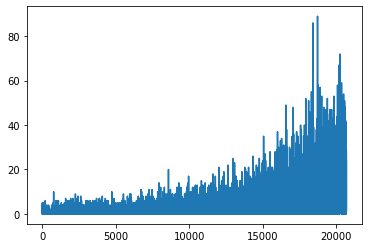

****************************************************     Episode Summary: 20800    *****************************************************
Training Done with error : [0.005595261, 0.6355467, 0.13921466]


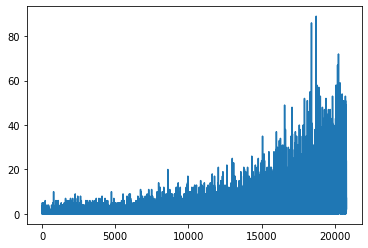

****************************************************     Episode Summary: 20900    *****************************************************
Training Done with error : [0.0071867662, 0.6653964, 0.15018347]


****************************************************     Episode Summary: 21000    *****************************************************
Training Done with error : [0.0057613165, 0.65490854, 0.11156162]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 21100    *****************************************************
Training Done with error : [0.0059237992, 0.60487586, 0.10395503]


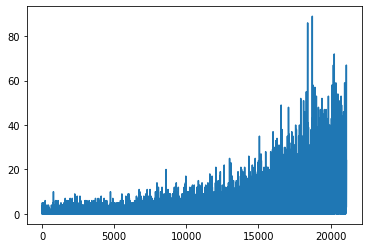

****************************************************     Episode Summary: 21200    *****************************************************
Training Done with error : [0.006120991, 0.6307187, 0.09727914]


****************************************************     Episode Summary: 21300    *****************************************************
Training Done with error : [0.006025589, 0.67149234, 0.110310495]


****************************************************     Episode Summary: 21400    *****************************************************
Training Done with error : [0.0059588035, 0.57198185, 0.08931963]


****************************************************     Episode Summary: 21500    *****************************************************
Training Done with error : [0.0056531136, 0.6095638, 0.1269566]


****************************************************     Episode Summary: 21600    *****************************************************
Training Done with error : [0.0057920287, 0.75972843, 0.1045495]


****************************************************     Episode Summary: 21700    *****************************************************
Training Done with error : [0.0063879443, 0.6661283, 0.069583856]


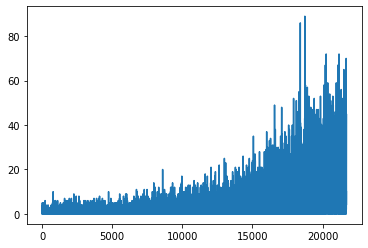

****************************************************     Episode Summary: 21800    *****************************************************
Training Done with error : [0.005829732, 0.6574648, 0.08145263]


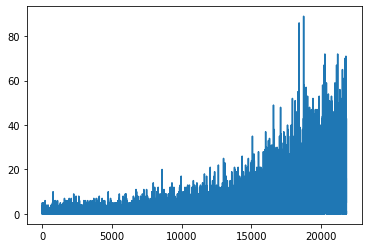

****************************************************     Episode Summary: 21900    *****************************************************
Training Done with error : [0.0060322094, 0.67227817, 0.07327882]


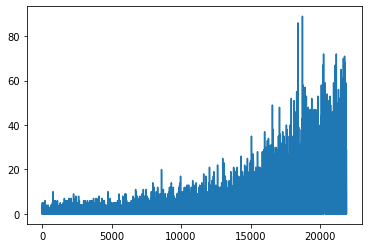

****************************************************     Episode Summary: 22000    *****************************************************
Training Done with error : [0.0058644363, 0.6102378, 0.058821943]


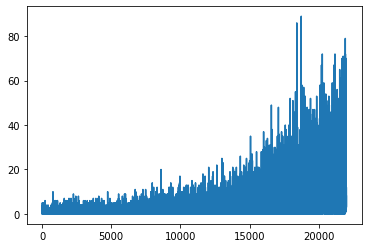

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 22100    *****************************************************
Training Done with error : [0.0055143274, 0.6489984, 0.04283575]


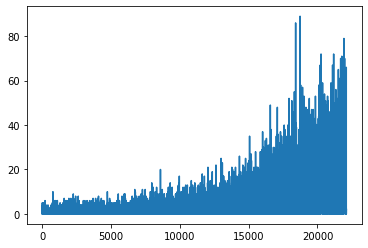

****************************************************     Episode Summary: 22200    *****************************************************
Training Done with error : [0.005518208, 0.6363181, 0.067067854]


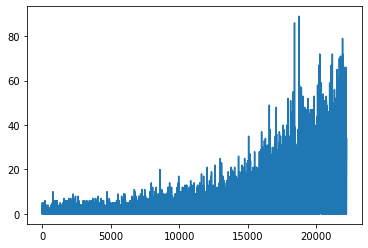

****************************************************     Episode Summary: 22300    *****************************************************
Training Done with error : [0.0058186734, 0.6904288, 0.06603257]


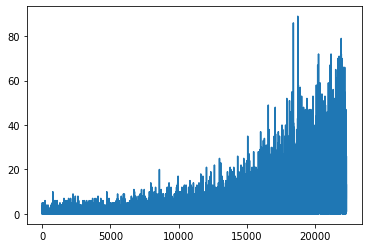

****************************************************     Episode Summary: 22400    *****************************************************
Training Done with error : [0.005797092, 0.62036705, 0.050425492]


****************************************************     Episode Summary: 22500    *****************************************************
Training Done with error : [0.005410365, 0.7335203, 0.032581184]


****************************************************     Episode Summary: 22600    *****************************************************
Training Done with error : [0.005421439, 0.70929575, 0.050025888]


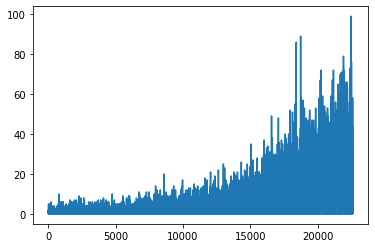

****************************************************     Episode Summary: 22700    *****************************************************
Training Done with error : [0.0056066182, 0.60619116, 0.036359586]


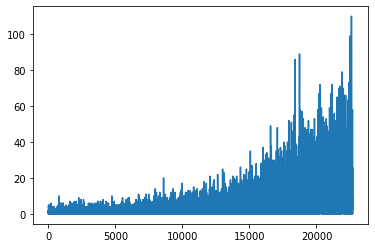

****************************************************     Episode Summary: 22800    *****************************************************
Training Done with error : [0.0058051962, 0.6034863, 0.057106458]


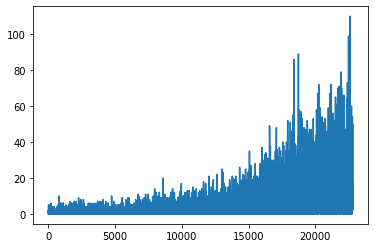

****************************************************     Episode Summary: 22900    *****************************************************
Training Done with error : [0.0062310174, 0.7043239, 0.04628864]


****************************************************     Episode Summary: 23000    *****************************************************
Training Done with error : [0.0060148854, 0.6285153, 0.035056647]


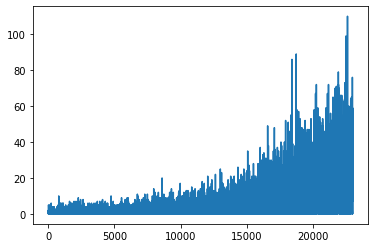

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 23100    *****************************************************
Training Done with error : [0.005650185, 0.5771151, 0.059092864]


****************************************************     Episode Summary: 23200    *****************************************************
Training Done with error : [0.0052675344, 0.59631544, 0.03599467]


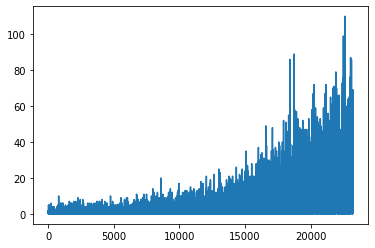

****************************************************     Episode Summary: 23300    *****************************************************
Training Done with error : [0.0048608687, 0.53714967, 0.040424198]


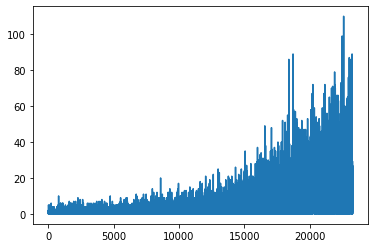

****************************************************     Episode Summary: 23400    *****************************************************
Training Done with error : [0.006036406, 0.6789305, 0.05145791]


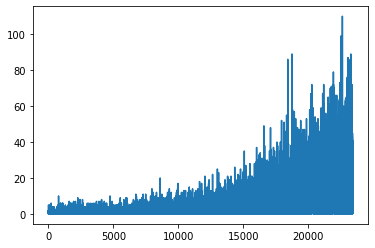

****************************************************     Episode Summary: 23500    *****************************************************
Training Done with error : [0.0052308706, 0.55947393, 0.06899608]


****************************************************     Episode Summary: 23600    *****************************************************
Training Done with error : [0.005564645, 0.49049208, 0.03442758]


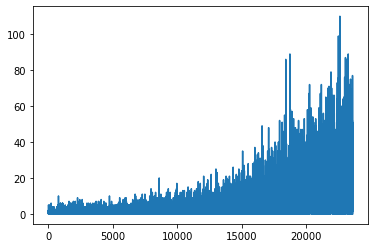

****************************************************     Episode Summary: 23700    *****************************************************
Training Done with error : [0.005311256, 0.5720043, 0.07122246]


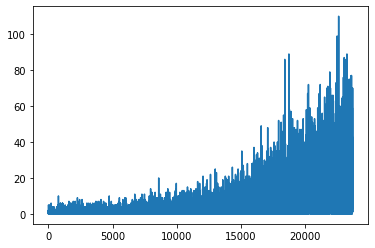

****************************************************     Episode Summary: 23800    *****************************************************
Training Done with error : [0.0051458958, 0.57174087, 0.047976717]


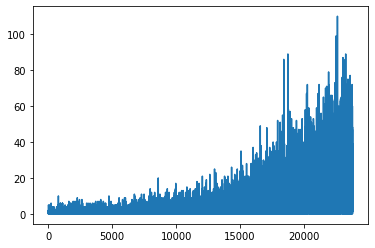

****************************************************     Episode Summary: 23900    *****************************************************
Training Done with error : [0.005095134, 0.6034622, 0.06827786]


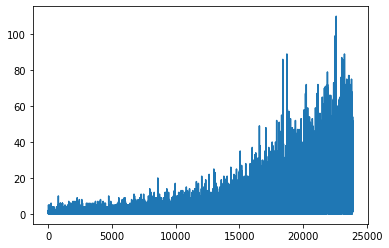

****************************************************     Episode Summary: 24000    *****************************************************
Training Done with error : [0.005655845, 0.49046898, 0.028997416]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 24100    *****************************************************
Training Done with error : [0.005740593, 0.58385694, 0.08828912]


****************************************************     Episode Summary: 24200    *****************************************************
Training Done with error : [0.004806413, 0.49239665, 0.056067277]


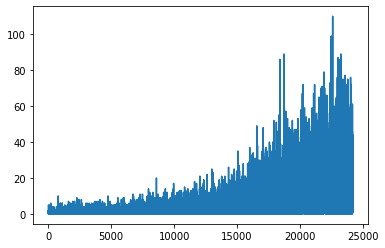

****************************************************     Episode Summary: 24300    *****************************************************
Training Done with error : [0.005184987, 0.5774065, 0.04580476]


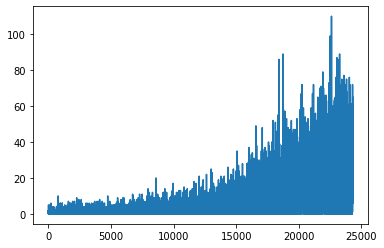

****************************************************     Episode Summary: 24400    *****************************************************
Training Done with error : [0.0050599515, 0.58026683, 0.027120667]


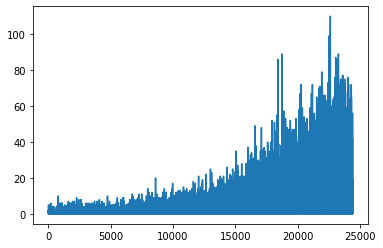

****************************************************     Episode Summary: 24500    *****************************************************
Training Done with error : [0.0052483752, 0.4747223, 0.041063413]


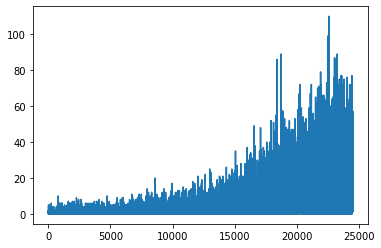

****************************************************     Episode Summary: 24600    *****************************************************
Training Done with error : [0.004872303, 0.51680744, 0.05753576]


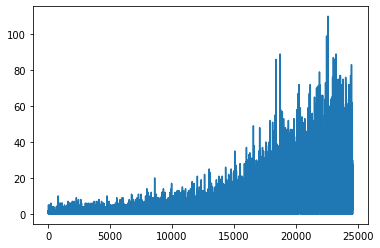

****************************************************     Episode Summary: 24700    *****************************************************
Training Done with error : [0.004841442, 0.4404229, 0.029902626]


****************************************************     Episode Summary: 24800    *****************************************************
Training Done with error : [0.0053603086, 0.5328828, 0.03933523]


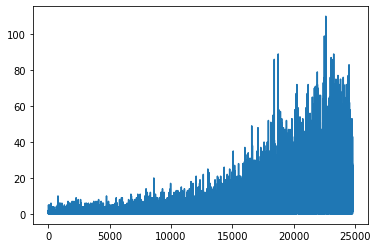

****************************************************     Episode Summary: 24900    *****************************************************
Training Done with error : [0.004893573, 0.5599089, 0.041743457]


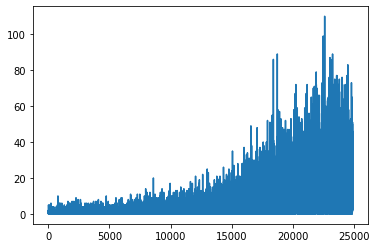

****************************************************     Episode Summary: 25000    *****************************************************
Training Done with error : [0.005586314, 0.55107707, 0.035631932]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 25100    *****************************************************
Training Done with error : [0.004837219, 0.569013, 0.046345454]


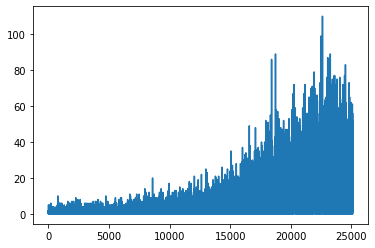

****************************************************     Episode Summary: 25200    *****************************************************
Training Done with error : [0.0042763697, 0.5681207, 0.04708533]


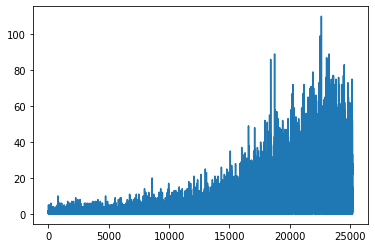

****************************************************     Episode Summary: 25300    *****************************************************
Training Done with error : [0.0047492855, 0.50153697, 0.06520039]


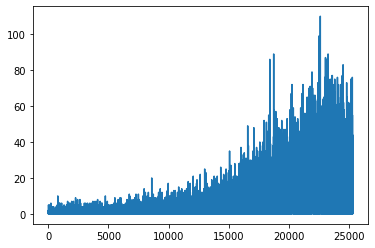

****************************************************     Episode Summary: 25400    *****************************************************
Training Done with error : [0.005200431, 0.5137837, 0.0673701]


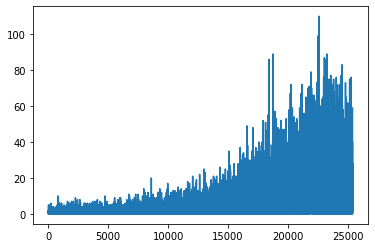

****************************************************     Episode Summary: 25500    *****************************************************
Training Done with error : [0.0044693807, 0.4787363, 0.046267092]


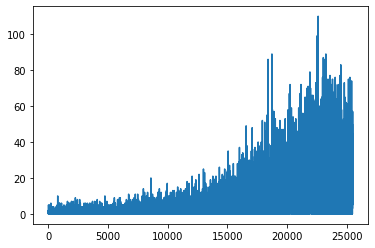

****************************************************     Episode Summary: 25600    *****************************************************
Training Done with error : [0.0052103945, 0.5697702, 0.054322977]


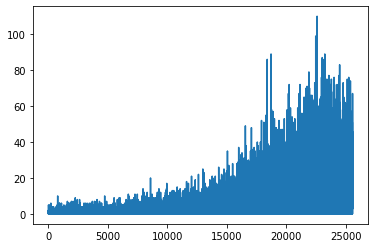

****************************************************     Episode Summary: 25700    *****************************************************
Training Done with error : [0.0045868335, 0.5525546, 0.050809942]


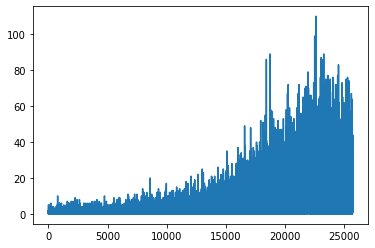

****************************************************     Episode Summary: 25800    *****************************************************
Training Done with error : [0.005111148, 0.5057208, 0.04474266]


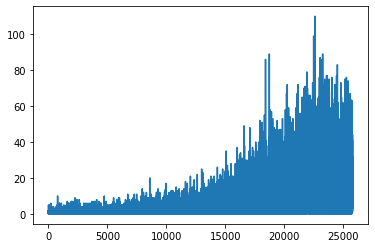

****************************************************     Episode Summary: 25900    *****************************************************
Training Done with error : [0.0049440516, 0.5620968, 0.035699032]


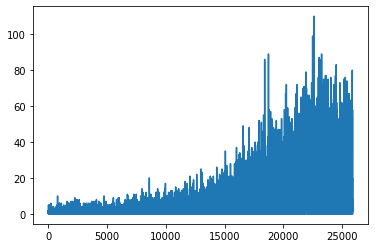

****************************************************     Episode Summary: 26000    *****************************************************
Training Done with error : [0.004870886, 0.6732757, 0.046250712]


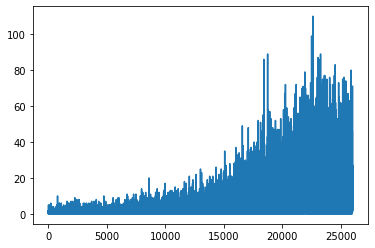

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 26100    *****************************************************
Training Done with error : [0.0046540615, 0.44806632, 0.044620264]


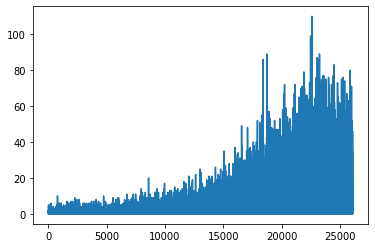

****************************************************     Episode Summary: 26200    *****************************************************
Training Done with error : [0.004867954, 0.5330312, 0.033747308]


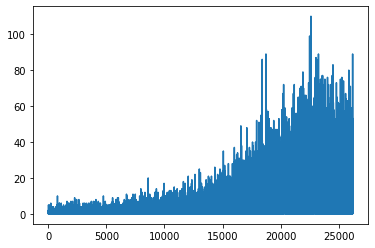

****************************************************     Episode Summary: 26300    *****************************************************
Training Done with error : [0.005005024, 0.53240025, 0.043130413]


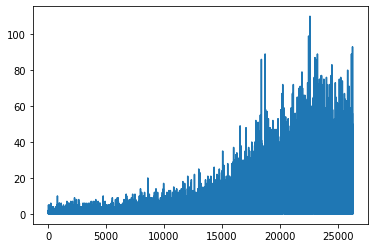

****************************************************     Episode Summary: 26400    *****************************************************
Training Done with error : [0.004423137, 0.54765964, 0.02333697]


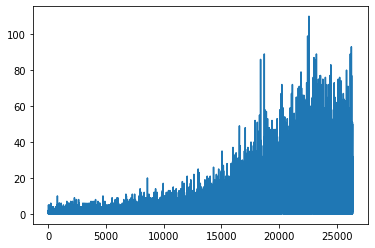

****************************************************     Episode Summary: 26500    *****************************************************
Training Done with error : [0.004955107, 0.6437134, 0.040264998]


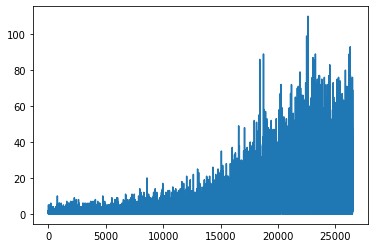

****************************************************     Episode Summary: 26600    *****************************************************
Training Done with error : [0.0053028218, 0.50903153, 0.051034685]


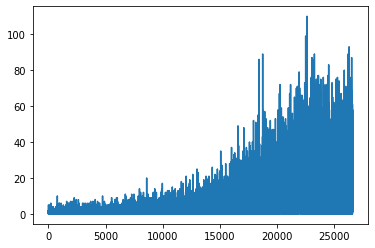

****************************************************     Episode Summary: 26700    *****************************************************
Training Done with error : [0.0051498637, 0.43780097, 0.03502259]


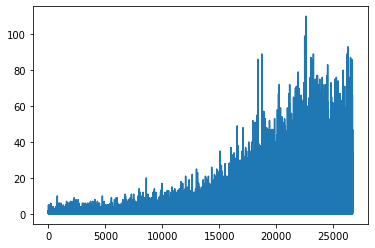

****************************************************     Episode Summary: 26800    *****************************************************
Training Done with error : [0.004696717, 0.48998225, 0.048353083]


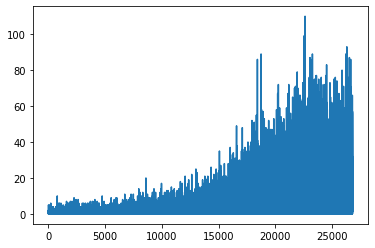

****************************************************     Episode Summary: 26900    *****************************************************
Training Done with error : [0.004891745, 0.47434568, 0.057009958]


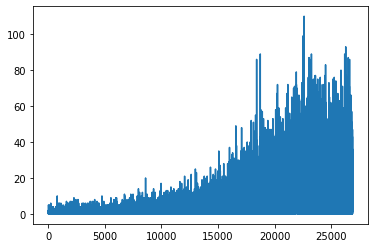

****************************************************     Episode Summary: 27000    *****************************************************
Training Done with error : [0.005071949, 0.50843495, 0.056501627]


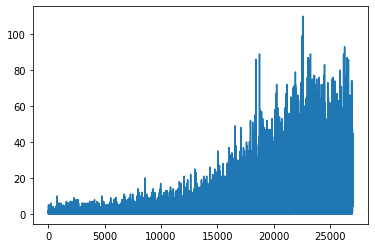

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 27100    *****************************************************
Training Done with error : [0.0048808833, 0.4713638, 0.045561474]


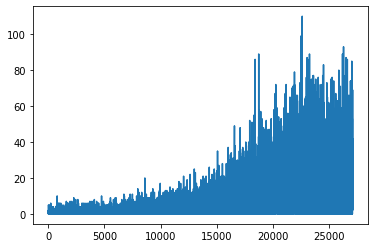

****************************************************     Episode Summary: 27200    *****************************************************
Training Done with error : [0.0046951007, 0.44243708, 0.036564413]


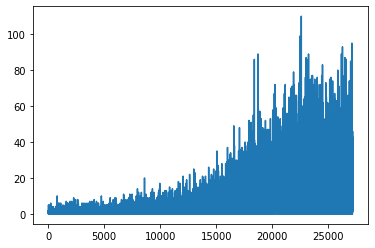

****************************************************     Episode Summary: 27300    *****************************************************
Training Done with error : [0.004816047, 0.42788818, 0.032023024]


****************************************************     Episode Summary: 27400    *****************************************************
Training Done with error : [0.005433918, 0.45449632, 0.0472354]


****************************************************     Episode Summary: 27500    *****************************************************
Training Done with error : [0.0051372983, 0.5162485, 0.07259423]


****************************************************     Episode Summary: 27600    *****************************************************
Training Done with error : [0.0045431657, 0.5335475, 0.055257283]


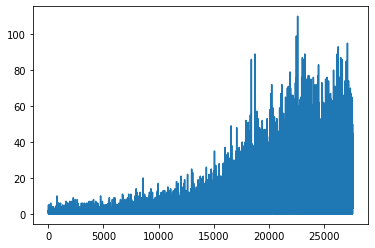

****************************************************     Episode Summary: 27700    *****************************************************
Training Done with error : [0.0043713786, 0.50476336, 0.11207141]


****************************************************     Episode Summary: 27800    *****************************************************
Training Done with error : [0.005233793, 0.5044573, 0.08123117]


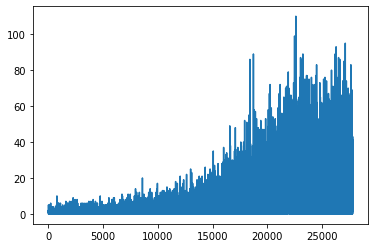

****************************************************     Episode Summary: 27900    *****************************************************
Training Done with error : [0.0046372665, 0.63646334, 0.058215603]


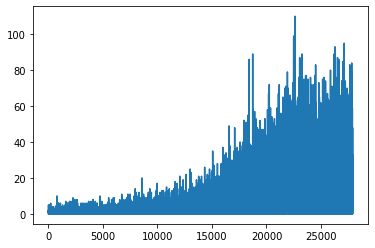

****************************************************     Episode Summary: 28000    *****************************************************
Training Done with error : [0.00483021, 0.6287015, 0.03326637]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 28100    *****************************************************
Training Done with error : [0.005164535, 0.4585843, 0.07158351]


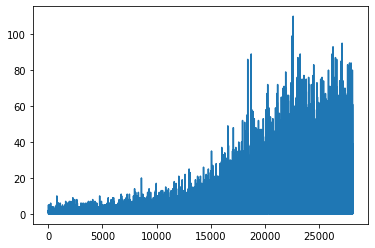

****************************************************     Episode Summary: 28200    *****************************************************
Training Done with error : [0.004839017, 0.42729214, 0.054063026]


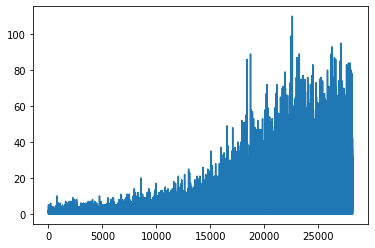

****************************************************     Episode Summary: 28300    *****************************************************
Training Done with error : [0.004024426, 0.5000662, 0.046612505]


****************************************************     Episode Summary: 28400    *****************************************************
Training Done with error : [0.0047474303, 0.48271853, 0.03595317]


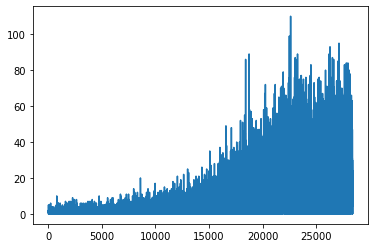

****************************************************     Episode Summary: 28500    *****************************************************
Training Done with error : [0.004960728, 0.53134286, 0.045379292]


****************************************************     Episode Summary: 28600    *****************************************************
Training Done with error : [0.004740103, 0.4284561, 0.053918466]


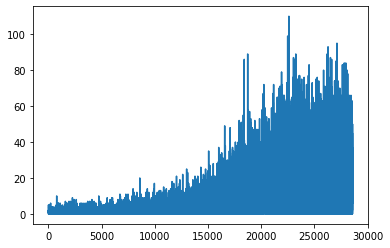

****************************************************     Episode Summary: 28700    *****************************************************
Training Done with error : [0.0048662666, 0.50828916, 0.036183532]


****************************************************     Episode Summary: 28800    *****************************************************
Training Done with error : [0.004291069, 0.63290626, 0.061391294]


****************************************************     Episode Summary: 28900    *****************************************************
Training Done with error : [0.004419255, 0.55205023, 0.0502643]


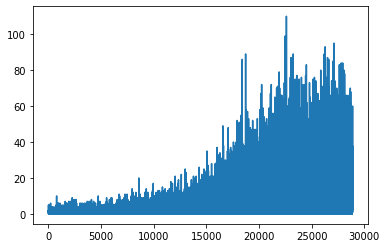

****************************************************     Episode Summary: 29000    *****************************************************
Training Done with error : [0.0044430206, 0.43630588, 0.023301437]


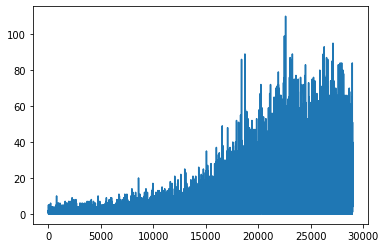

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 29100    *****************************************************
Training Done with error : [0.0048228083, 0.45869157, 0.02237847]


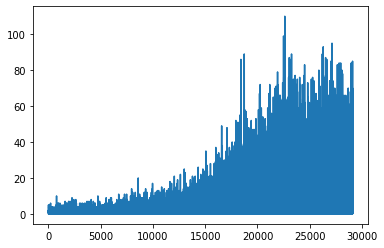

****************************************************     Episode Summary: 29200    *****************************************************
Training Done with error : [0.0037720224, 0.5137837, 0.084346645]


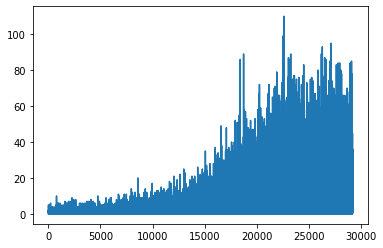

****************************************************     Episode Summary: 29300    *****************************************************
Training Done with error : [0.0046638185, 0.49862063, 0.049540233]


****************************************************     Episode Summary: 29400    *****************************************************
Training Done with error : [0.004446106, 0.57329834, 0.052548185]


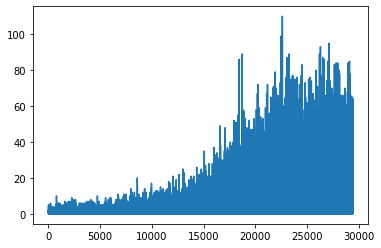

****************************************************     Episode Summary: 29500    *****************************************************
Training Done with error : [0.004656638, 0.44902712, 0.071969345]


****************************************************     Episode Summary: 29600    *****************************************************
Training Done with error : [0.004547757, 0.50985706, 0.032822527]


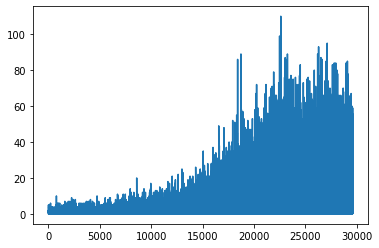

****************************************************     Episode Summary: 29700    *****************************************************
Training Done with error : [0.0052776346, 0.5050455, 0.04563413]


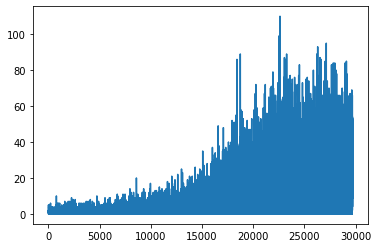

****************************************************     Episode Summary: 29800    *****************************************************
Training Done with error : [0.0041481764, 0.4854036, 0.043386657]


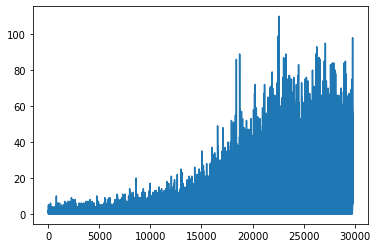

****************************************************     Episode Summary: 29900    *****************************************************
Training Done with error : [0.0044420413, 0.47470737, 0.03494386]


****************************************************     Episode Summary: 30000    *****************************************************
Training Done with error : [0.004336108, 0.49126852, 0.022241708]


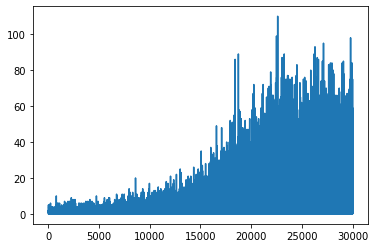

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 30100    *****************************************************
Training Done with error : [0.0042926404, 0.68119353, 0.020932024]


****************************************************     Episode Summary: 30200    *****************************************************
Training Done with error : [0.0044973977, 0.53274286, 0.038503464]


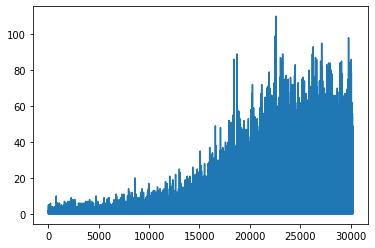

****************************************************     Episode Summary: 30300    *****************************************************
Training Done with error : [0.004882864, 0.45242137, 0.022867003]


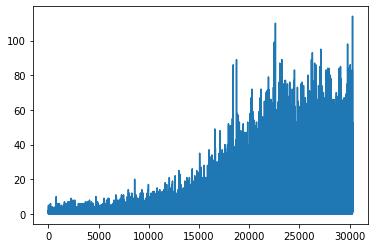

****************************************************     Episode Summary: 30400    *****************************************************
Training Done with error : [0.004746777, 0.44978324, 0.05227521]


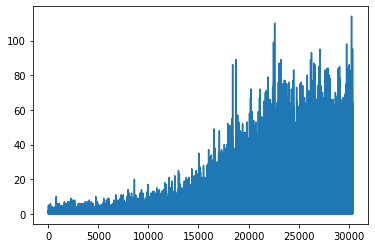

****************************************************     Episode Summary: 30500    *****************************************************
Training Done with error : [0.0039092936, 0.54527795, 0.038352855]


****************************************************     Episode Summary: 30600    *****************************************************
Training Done with error : [0.0044646175, 0.6188511, 0.02806722]


****************************************************     Episode Summary: 30700    *****************************************************
Training Done with error : [0.004173437, 0.62277055, 0.0205523]


****************************************************     Episode Summary: 30800    *****************************************************
Training Done with error : [0.0043679383, 0.45671767, 0.022536077]


****************************************************     Episode Summary: 30900    *****************************************************
Training Done with error : [0.004246802, 0.5585305, 0.045413647]


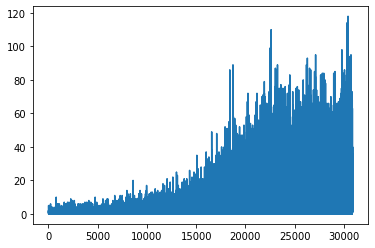

****************************************************     Episode Summary: 31000    *****************************************************
Training Done with error : [0.0041930643, 0.47827116, 0.029954523]


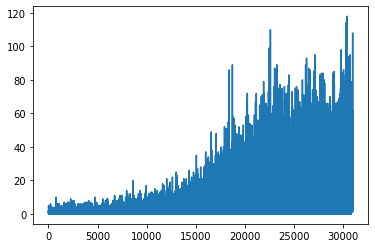

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 31100    *****************************************************
Training Done with error : [0.004233931, 0.45972815, 0.023567617]


****************************************************     Episode Summary: 31200    *****************************************************
Training Done with error : [0.0041791275, 0.43777135, 0.027920859]


****************************************************     Episode Summary: 31300    *****************************************************
Training Done with error : [0.004291366, 0.50474817, 0.02793932]


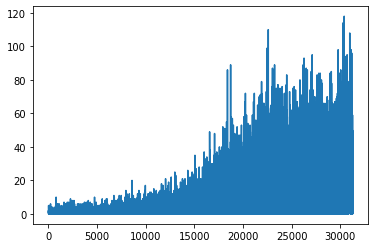

****************************************************     Episode Summary: 31400    *****************************************************
Training Done with error : [0.0042936825, 0.39531282, 0.035071753]


****************************************************     Episode Summary: 31500    *****************************************************
Training Done with error : [0.004296188, 0.51446056, 0.042282432]


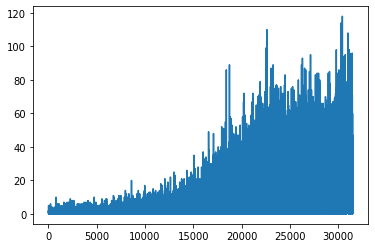

****************************************************     Episode Summary: 31600    *****************************************************
Training Done with error : [0.004350747, 0.55989957, 0.05532145]


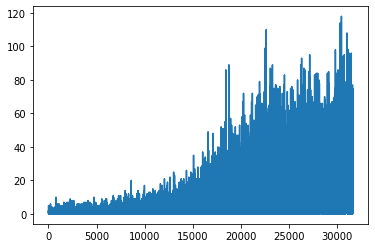

****************************************************     Episode Summary: 31700    *****************************************************
Training Done with error : [0.003698442, 0.47537857, 0.040634416]


****************************************************     Episode Summary: 31800    *****************************************************
Training Done with error : [0.004866774, 0.49147305, 0.035081074]


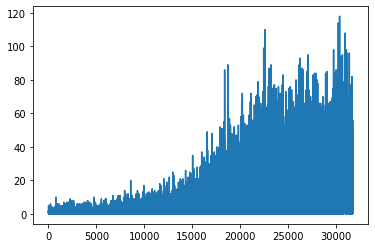

****************************************************     Episode Summary: 31900    *****************************************************
Training Done with error : [0.0037796947, 0.46242988, 0.07858127]


****************************************************     Episode Summary: 32000    *****************************************************
Training Done with error : [0.004362123, 0.4112197, 0.03227234]


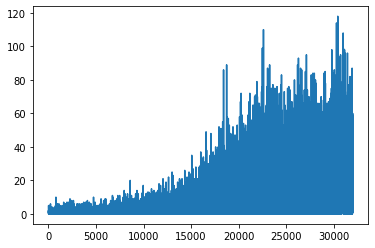

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 32100    *****************************************************
Training Done with error : [0.004878916, 0.5432087, 0.052334663]


****************************************************     Episode Summary: 32200    *****************************************************
Training Done with error : [0.004095273, 0.44558626, 0.040357467]


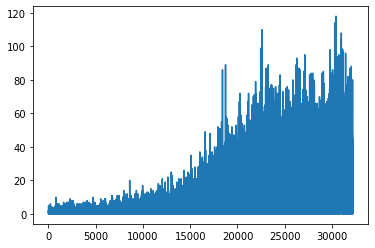

****************************************************     Episode Summary: 32300    *****************************************************
Training Done with error : [0.004899838, 0.49018565, 0.044239126]


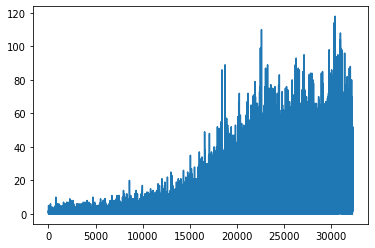

****************************************************     Episode Summary: 32400    *****************************************************
Training Done with error : [0.0046582394, 0.39107797, 0.035016797]


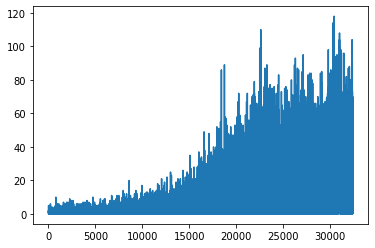

****************************************************     Episode Summary: 32500    *****************************************************
Training Done with error : [0.004661145, 0.45005253, 0.05169789]


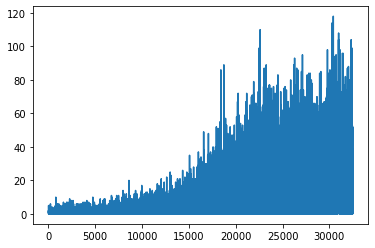

****************************************************     Episode Summary: 32600    *****************************************************
Training Done with error : [0.005253854, 0.40156427, 0.019172536]


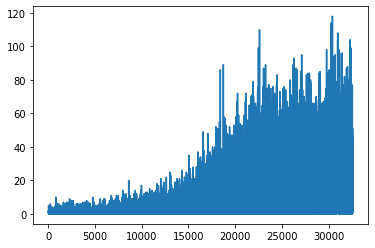

****************************************************     Episode Summary: 32700    *****************************************************
Training Done with error : [0.004191822, 0.53362864, 0.017916538]


****************************************************     Episode Summary: 32800    *****************************************************
Training Done with error : [0.004227539, 0.5053479, 0.019201653]


****************************************************     Episode Summary: 32900    *****************************************************
Training Done with error : [0.004242151, 0.42664394, 0.018893601]


****************************************************     Episode Summary: 33000    *****************************************************
Training Done with error : [0.004174442, 0.42676133, 0.028981656]


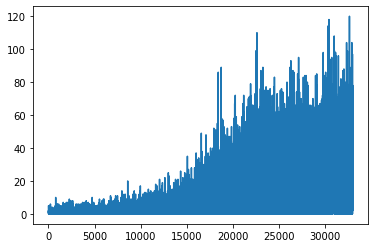

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 33100    *****************************************************
Training Done with error : [0.003975228, 0.42226753, 0.035350036]


****************************************************     Episode Summary: 33200    *****************************************************
Training Done with error : [0.003993941, 0.49713078, 0.032425627]


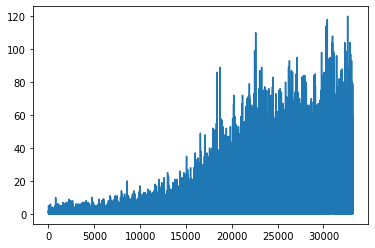

****************************************************     Episode Summary: 33300    *****************************************************
Training Done with error : [0.00404238, 0.42099646, 0.062200688]


****************************************************     Episode Summary: 33400    *****************************************************
Training Done with error : [0.0045328173, 0.5097599, 0.025935957]


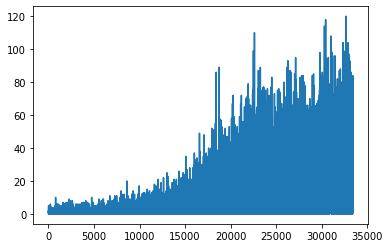

****************************************************     Episode Summary: 33500    *****************************************************
Training Done with error : [0.0044369553, 0.46443084, 0.01787035]


****************************************************     Episode Summary: 33600    *****************************************************
Training Done with error : [0.0045763203, 0.5084295, 0.04415677]


****************************************************     Episode Summary: 33700    *****************************************************
Training Done with error : [0.004504407, 0.45122606, 0.022139216]


****************************************************     Episode Summary: 33800    *****************************************************
Training Done with error : [0.0037816316, 0.4110273, 0.033261433]


****************************************************     Episode Summary: 33900    *****************************************************
Training Done with error : [0.0042040073, 0.4840031, 0.03988588]


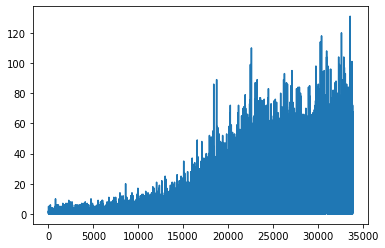

****************************************************     Episode Summary: 34000    *****************************************************
Training Done with error : [0.0046569942, 0.4226871, 0.033371247]


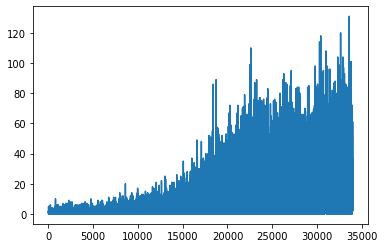

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 34100    *****************************************************
Training Done with error : [0.004089639, 0.41935083, 0.031544782]


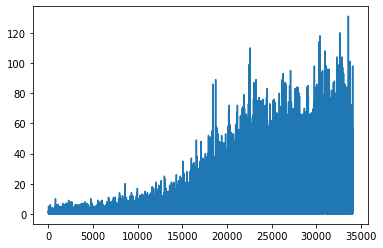

****************************************************     Episode Summary: 34200    *****************************************************
Training Done with error : [0.0043358025, 0.45038423, 0.026070096]


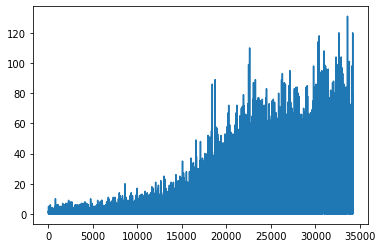

****************************************************     Episode Summary: 34300    *****************************************************
Training Done with error : [0.0039482284, 0.3845823, 0.041315593]


****************************************************     Episode Summary: 34400    *****************************************************
Training Done with error : [0.0037928398, 0.42520317, 0.04383828]


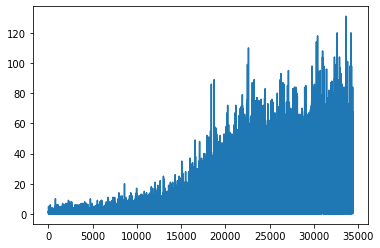

****************************************************     Episode Summary: 34500    *****************************************************
Training Done with error : [0.003811725, 0.42720628, 0.04004187]


****************************************************     Episode Summary: 34600    *****************************************************
Training Done with error : [0.003966103, 0.39795387, 0.051072624]


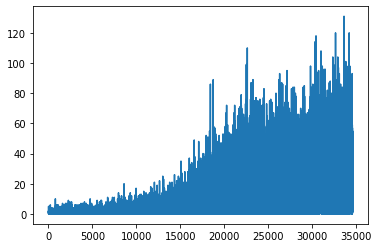

****************************************************     Episode Summary: 34700    *****************************************************
Training Done with error : [0.0043380447, 0.511953, 0.03286833]


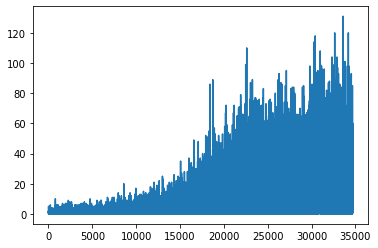

****************************************************     Episode Summary: 34800    *****************************************************
Training Done with error : [0.004023028, 0.4883292, 0.054449923]


****************************************************     Episode Summary: 34900    *****************************************************
Training Done with error : [0.0037746415, 0.42549863, 0.04507803]


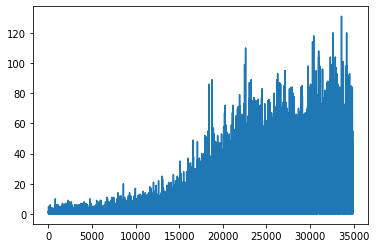

****************************************************     Episode Summary: 35000    *****************************************************
Training Done with error : [0.003720598, 0.48126954, 0.04759613]


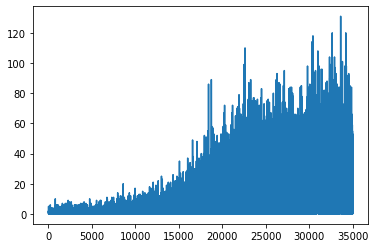

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 35100    *****************************************************
Training Done with error : [0.0042357636, 0.37025815, 0.031610213]


****************************************************     Episode Summary: 35200    *****************************************************
Training Done with error : [0.0038757112, 0.4047021, 0.030536221]


****************************************************     Episode Summary: 35300    *****************************************************
Training Done with error : [0.0036524918, 0.4382972, 0.017499793]


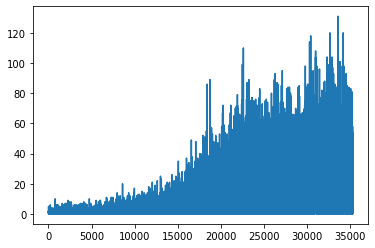

****************************************************     Episode Summary: 35400    *****************************************************
Training Done with error : [0.0038934469, 0.37405893, 0.050676025]


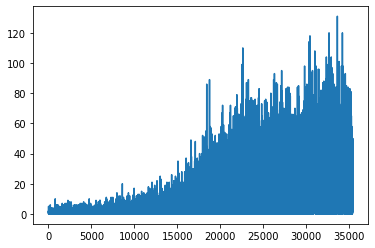

****************************************************     Episode Summary: 35500    *****************************************************
Training Done with error : [0.004054534, 0.415388, 0.03845597]


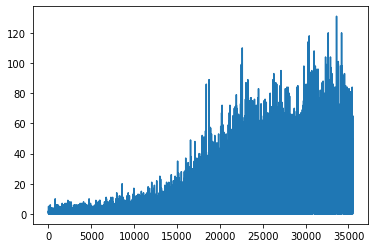

****************************************************     Episode Summary: 35600    *****************************************************
Training Done with error : [0.003823978, 0.40733328, 0.04156509]


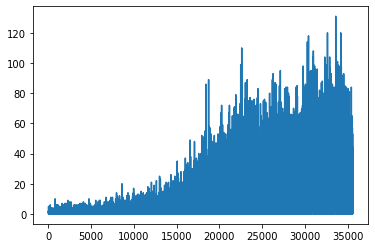

****************************************************     Episode Summary: 35700    *****************************************************
Training Done with error : [0.0038952092, 0.41264153, 0.036967404]


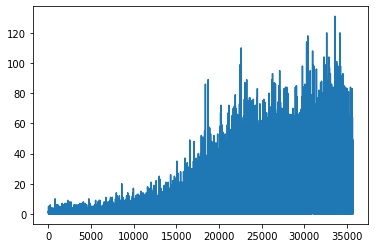

****************************************************     Episode Summary: 35800    *****************************************************
Training Done with error : [0.0040909355, 0.40781486, 0.037220754]


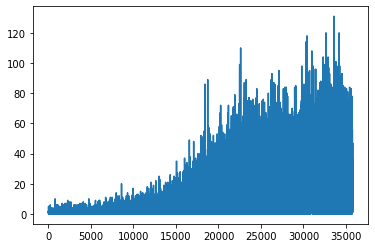

****************************************************     Episode Summary: 35900    *****************************************************
Training Done with error : [0.0040572905, 0.33600885, 0.034514144]


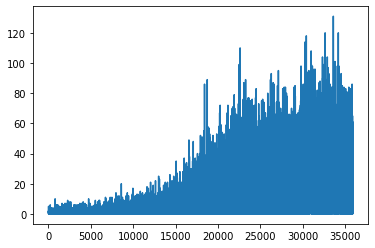

****************************************************     Episode Summary: 36000    *****************************************************
Training Done with error : [0.0040645627, 0.6077425, 0.029737074]


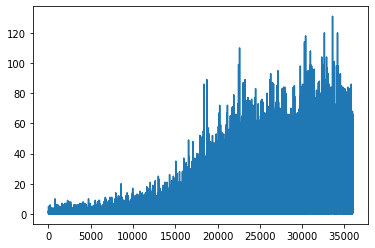

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 36100    *****************************************************
Training Done with error : [0.004452479, 0.5415817, 0.028345078]


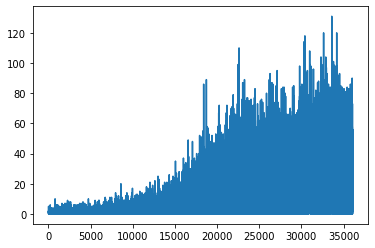

****************************************************     Episode Summary: 36200    *****************************************************
Training Done with error : [0.0038760502, 0.37815413, 0.050004534]


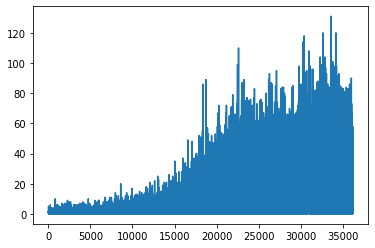

****************************************************     Episode Summary: 36300    *****************************************************
Training Done with error : [0.004354601, 0.4683597, 0.04660464]


****************************************************     Episode Summary: 36400    *****************************************************
Training Done with error : [0.0033636154, 0.43071786, 0.04221513]


****************************************************     Episode Summary: 36500    *****************************************************
Training Done with error : [0.0041792775, 0.46357995, 0.08521549]


****************************************************     Episode Summary: 36600    *****************************************************
Training Done with error : [0.0036922388, 0.42919937, 0.029285831]


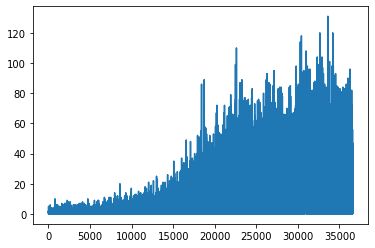

****************************************************     Episode Summary: 36700    *****************************************************
Training Done with error : [0.0042158025, 0.48432797, 0.07296822]


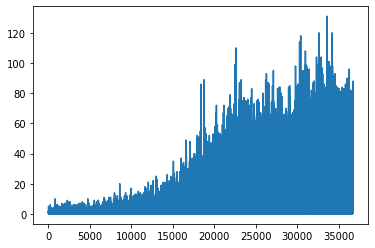

****************************************************     Episode Summary: 36800    *****************************************************
Training Done with error : [0.0034411522, 0.5151874, 0.04772207]


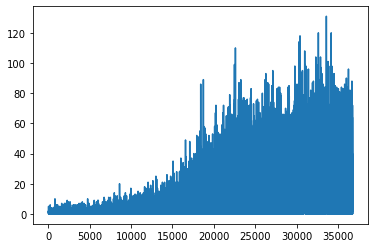

****************************************************     Episode Summary: 36900    *****************************************************
Training Done with error : [0.0035754377, 0.36921927, 0.038450655]


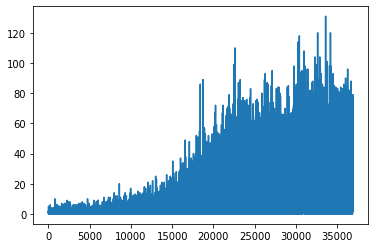

****************************************************     Episode Summary: 37000    *****************************************************
Training Done with error : [0.003413201, 0.466793, 0.04186889]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 37100    *****************************************************
Training Done with error : [0.0036124089, 0.4980767, 0.03923342]


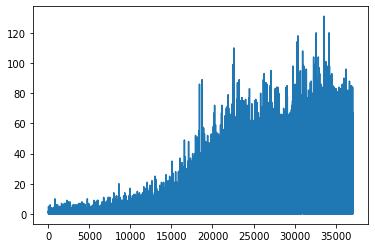

****************************************************     Episode Summary: 37200    *****************************************************
Training Done with error : [0.0039005321, 0.5288559, 0.09238685]


****************************************************     Episode Summary: 37300    *****************************************************
Training Done with error : [0.003974992, 0.5179202, 0.043322023]


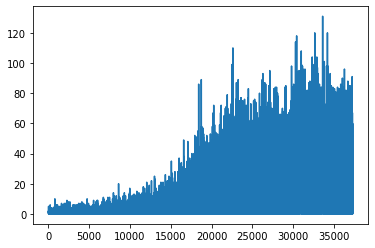

****************************************************     Episode Summary: 37400    *****************************************************
Training Done with error : [0.0037399128, 0.4817479, 0.082238585]


****************************************************     Episode Summary: 37500    *****************************************************
Training Done with error : [0.0034368255, 0.40622053, 0.073502734]


****************************************************     Episode Summary: 37600    *****************************************************
Training Done with error : [0.0039594322, 0.35982043, 0.05068972]


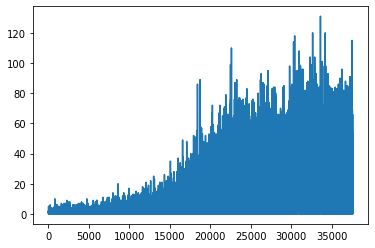

****************************************************     Episode Summary: 37700    *****************************************************
Training Done with error : [0.0041010175, 0.4256022, 0.05084059]


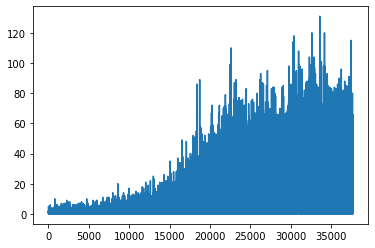

****************************************************     Episode Summary: 37800    *****************************************************
Training Done with error : [0.003786252, 0.503251, 0.08952222]


****************************************************     Episode Summary: 37900    *****************************************************
Training Done with error : [0.0039141984, 0.47226414, 0.05799967]


****************************************************     Episode Summary: 38000    *****************************************************
Training Done with error : [0.003674268, 0.48994592, 0.027482307]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 38100    *****************************************************
Training Done with error : [0.00419876, 0.38949314, 0.08414479]


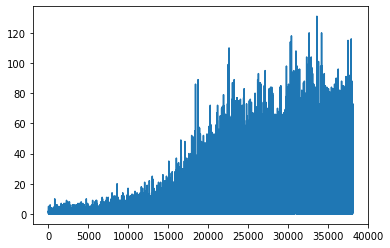

****************************************************     Episode Summary: 38200    *****************************************************
Training Done with error : [0.00341134, 0.36683732, 0.063726865]


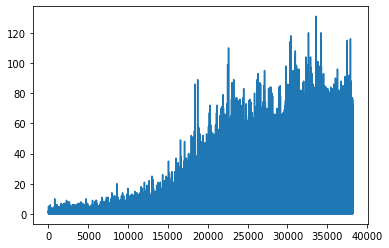

****************************************************     Episode Summary: 38300    *****************************************************
Training Done with error : [0.003633525, 0.40840957, 0.07308931]


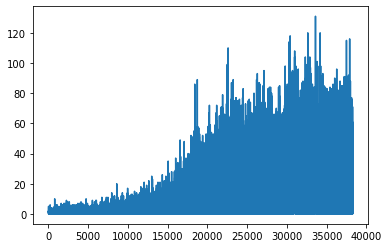

****************************************************     Episode Summary: 38400    *****************************************************
Training Done with error : [0.003924199, 0.37930766, 0.1232746]


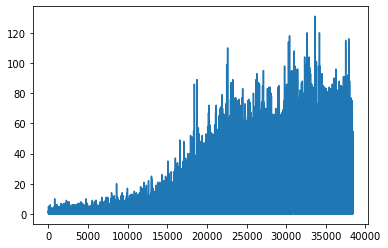

****************************************************     Episode Summary: 38500    *****************************************************
Training Done with error : [0.0038412544, 0.45375657, 0.05187529]


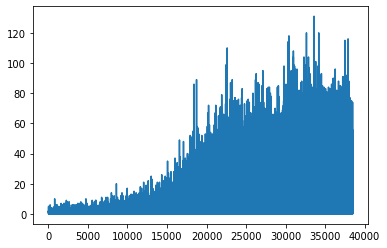

****************************************************     Episode Summary: 38600    *****************************************************
Training Done with error : [0.0036214252, 0.44729918, 0.06310171]


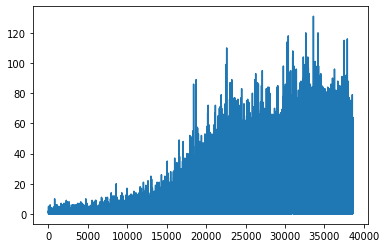

****************************************************     Episode Summary: 38700    *****************************************************
Training Done with error : [0.0035789025, 0.5240192, 0.078321375]


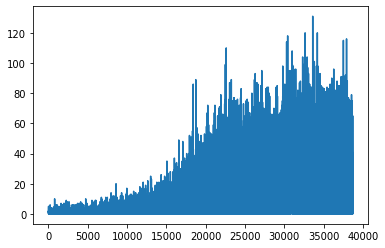

****************************************************     Episode Summary: 38800    *****************************************************
Training Done with error : [0.0036542425, 0.45696166, 0.054054815]


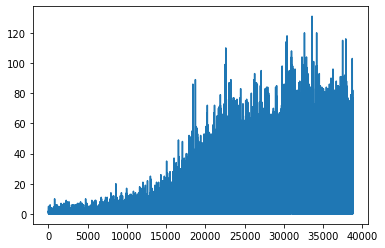

****************************************************     Episode Summary: 38900    *****************************************************
Training Done with error : [0.0032680146, 0.5269822, 0.06293985]


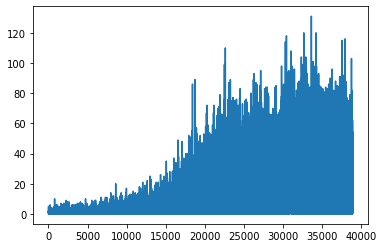

****************************************************     Episode Summary: 39000    *****************************************************
Training Done with error : [0.0036629234, 0.3409213, 0.033087302]


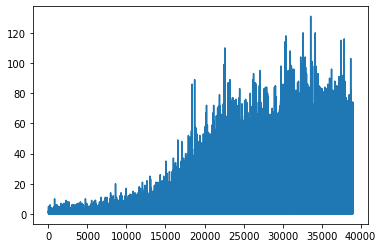

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
****************************************************     Episode Summary: 39100    *****************************************************
Training Done with error : [0.0037457547, 0.39224172, 0.043038823]


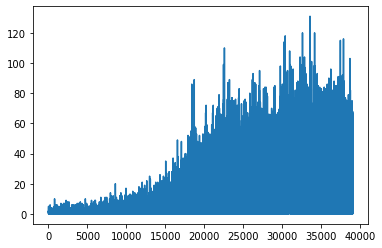

****************************************************     Episode Summary: 39200    *****************************************************
Training Done with error : [0.003485862, 0.4578474, 0.019946847]


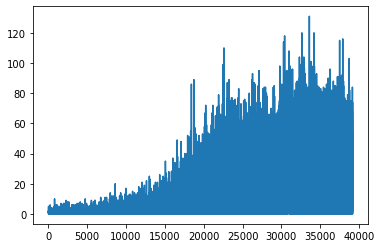

****************************************************     Episode Summary: 39300    *****************************************************
Training Done with error : [0.0035656672, 0.43362573, 0.050872345]


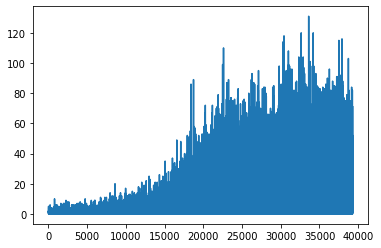

****************************************************     Episode Summary: 39400    *****************************************************
Training Done with error : [0.0037510584, 0.3847813, 0.075535595]


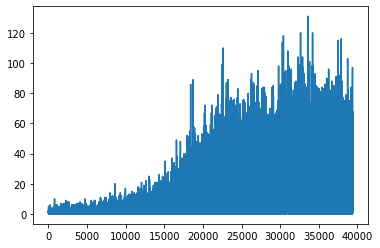

****************************************************     Episode Summary: 39500    *****************************************************
Training Done with error : [0.0035382498, 0.52508503, 0.073819056]


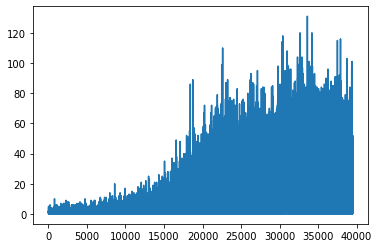

****************************************************     Episode Summary: 39600    *****************************************************
Training Done with error : [0.0040379073, 0.43044233, 0.021342266]


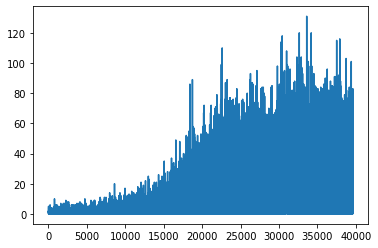

****************************************************     Episode Summary: 39700    *****************************************************
Training Done with error : [0.00413586, 0.49993446, 0.02341136]


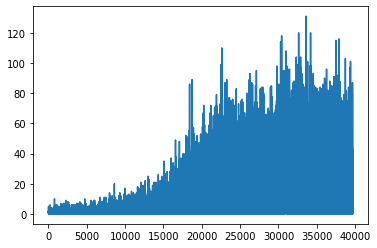

****************************************************     Episode Summary: 39800    *****************************************************
Training Done with error : [0.0040074294, 0.3932088, 0.013837967]


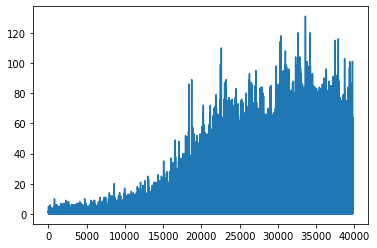

****************************************************     Episode Summary: 39900    *****************************************************
Training Done with error : [0.0038296997, 0.46553284, 0.03769436]


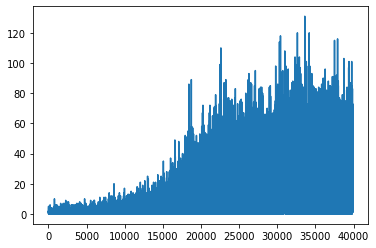

In [0]:
brain.train()

In [0]:
# inp = Input(shape=(4,))
# z = Dense(8, activation='relu')(inp)
# out = Dense(3, activation='softmax')(z)
# model = Model(inputs=[inp], outputs=out)
# # sgd = optimizers.SGD(lr=0.0001)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_0 = clone_model(model)
# model_0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_1 = clone_model(model)
# model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_arr = [model_0, model_1]
# # print(len(model_arr))
# iris_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/iris.data",header=None)
# # print(cereal_df.head(5))
# data = iris_df.to_numpy()
# Y = data[:,-1]
# enc = OneHotEncoder()
# Y = enc.fit_transform(data[:,-1].reshape(-1, 1))
# X = data[:,0:4]
# # Y = data[:,-1]
# # model_arr[0].fit(X, Y, epochs=10, verbose=1, validation_split=0.2, shuffle=True)
# # model_arr[1].fit(X, Y, epochs=50, verbose=1, validation_split=0.2, shuffle=True)
# model_0.fit(X, Y, epochs=200, verbose=1, validation_split=0.2, shuffle=True)
# model_1.fit(X, Y, epochs=300, verbose=1, validation_split=0.2, shuffle=True)

In [0]:
# from sklearn.metrics import accuracy_score
# predicted = model_arr[1].predict(X)
# predicted = np.argmax(predicted, axis=1)
# print(predicted)
# accuracy_score(predicted, np.argmax(Y, axis=1))
# print(np.argmax(Y, axis=1))

39901


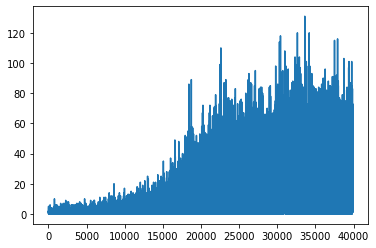

In [0]:
import pickle
infile = open("/content/drive/My Drive/Colab Notebooks/ep_len_array",'rb')
new_dict = pickle.load(infile)
infile.close()
plt.plot(new_dict)
print(len(new_dict))

In [0]:
import sklearn
# brain.qnetwork.load("/content/drive/My Drive/Colab Notebooks/iris_model.h5")
preds = brain.model_predict(brain.env.data_X)
# print(preds)
print(sklearn.metrics.accuracy_score(preds,brain.env.data_Y))

0.9666666666666667
